In [2]:
from collections import defaultdict
from itertools import islice, product
import random
import time
from pathlib import Path

import numpy as np
from tqdm.auto import tqdm

import pandas as pd
from sympy import parse_expr, lambdify

import torch
import torch.nn as nn

# import seml
# from sacred import Experiment
# from sacred.utils import apply_backspaces_and_linefeeds
# ex = Experiment("feynman-network-subexperiment-v2-simplexcompare")
# ex.captured_out_filter = apply_backspaces_and_linefeeds

In [3]:
def parameters(width, depth, dimension):
    """Computes number of parameters in MLP with widths `width`,
    depth `depth`, and input dimension `dimension`. Assumes the neurons
    have biases.
    """
    return (dimension * width + width) + (depth - 2)*(width * width + width) + (width + 1)

def width_given_ddp(depth, dimension, parameters):
    """Given the network depth and input dimension, computes the
    width such that the architecture (with bias) has `parameters` parameters.
    """
    if depth == 2:
        return int((parameters - 1) / (dimension + 2))
    root = (-(dimension + depth) + np.sqrt(np.power(dimension + depth, 2) - 4 * (depth - 2) * (1 - parameters))) / (2 * (depth - 2))
    return int(root)

In [3]:
# @ex.post_run_hook
# def collect_stats(_run):
#     seml.collect_exp_stats(_run)

# # --------------------------
# #    ,-------------.
# #   (_\  CONFIG     \
# #      |    OF      |
# #      |    THE     |
# #     _| EXPERIMENT |
# #    (_/_____(*)___/
# #             \\
# #              ))
# #              ^
# # --------------------------
# @ex.config
# def cfg():
#     eqn = 'I.10.7'
#     width = 100
#     depth = 3
#     lr = 1e-3
#     activation = 'ReLU'
#     N_TEST_POINTS = 30000
#     TEST_COMPACTIFICATION = 0.8
#     MAX_TRAIN_ITERS = 25000
#     MAX_BATCH_SIZE = 30000
#     spreadsheet = "/om2/user/ericjm/precision-ml/equations.csv"
#     device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#     dtype = torch.float64

#     overwrite = None
#     db_collection = None
#     if db_collection is not None:
#         ex.observers.append(seml.create_mongodb_observer(db_collection, overwrite=overwrite)

In [4]:
eqn = 'Z.001'
width = 100
depth = 3
lr = 1e-3
activation = 'ReLU'
N_TEST_POINTS = 30000
TEST_COMPACTIFICATION = 0.8
MAX_TRAIN_ITERS = 25000
MAX_BATCH_SIZE = 30000
spreadsheet = "../equations.csv"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 0

In [20]:
torch.set_default_dtype(dtype)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [21]:
device

device(type='cuda', index=0)

In [22]:
equations = pd.read_csv(spreadsheet)
row = equations[equations['Equation'] == eqn].iloc[0]
dimension = int(row['# variables'])
formula = row['Formula']
variables = [row[f'v{i}_name'] for i in range(1, dimension+1)]
ranges = [(row[f'v{i}_low'], row[f'v{i}_high']) for i in range(1, dimension+1)]
target = lambdify(variables, parse_expr(formula))


TRAIN_POINTS = parameters(width, depth, dimension) // (dimension + 1)
# ex.info['TRAIN_POINTS'] = TRAIN_POINTS
# _log.debug(f"TRAIN_POINTS: {TRAIN_POINTS}")

# create datasets
ls = np.array([ranges[i][0] for i in range(dimension)])
hs = np.array([ranges[i][1] for i in range(dimension)])
xs_train = np.random.uniform(low=ls, high=hs, size=(TRAIN_POINTS, dimension))
ys_train = target(*[xs_train[:, i] for i in range(dimension)])

cs = (hs + ls) / 2
ws = (hs - ls) * TEST_COMPACTIFICATION
ls, hs = cs - ws / 2, cs + ws / 2
xs_test = np.random.uniform(low=ls, high=hs, size=(N_TEST_POINTS, dimension))
ys_test = target(*[xs_test[:, i] for i in range(dimension)])

xs_train = torch.from_numpy(xs_train).to(device)
ys_train = torch.from_numpy(ys_train).to(device).unsqueeze(dim=1)
xs_test = torch.from_numpy(xs_test).to(device)
ys_test = torch.from_numpy(ys_test).to(device).unsqueeze(dim=1)

## Simplex interpolation first

In [23]:
from scipy import spatial, interpolate

# xs_train = xs_train.reshape((TRAIN_POINTS,))
# ys_train = ys_train.reshape((TRAIN_POINTS,))
# xs_test = xs_test.reshape((N_TEST_POINTS,))
# ys_test = ys_test.reshape((N_TEST_POINTS,))

f = interpolate.interp1d(xs_train.reshape((TRAIN_POINTS,)).cpu().detach().cpu().numpy(), ys_train.reshape((TRAIN_POINTS,)).detach().cpu().numpy(), kind='linear', bounds_error=False)

# _log.debug("Evaluating model") 
preds = f(xs_test.reshape((N_TEST_POINTS,)).detach().cpu().numpy())
valid_idx = ~np.isnan(preds)
rmse_loss = np.sqrt(np.mean(np.power(preds[valid_idx] - ys_test.reshape((N_TEST_POINTS,)).detach().cpu().numpy()[valid_idx], 2)))
# ex.info['test'] = rmse_loss.item() 

In [24]:
assert xs_train.dtype == dtype
assert ys_train.dtype == dtype
assert xs_test.dtype == dtype
assert ys_test.dtype == dtype

if activation == 'ReLU':
    activation_fn = nn.ReLU
elif activation == 'Tanh':
    activation_fn = nn.Tanh
elif activation == 'Sigmoid':
    activation_fn = nn.Sigmoid
else:
    assert False, f"Unrecognized activation function identifier: {activation}"

# create model
layers = []
for i in range(depth):
    if i == 0:
        layers.append(nn.Linear(dimension, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        layers.append(nn.Linear(width, 1))
    else:
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())
mlp = nn.Sequential(*layers).to(device)
# _log.debug("Created model.")
# _log.debug(f"Model has {sum(t.numel() for t in mlp.parameters())} parameters") 

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(mlp.parameters(), lr=lr)

# ex.info['train'] = list()
train = list()
# ex.info['test'] = list()
test = list()
min_train = float('inf')
min_test = float('inf')
test_at_min_train = float('inf')

k = 0
for step in tqdm(range(MAX_TRAIN_ITERS)):
    optim.zero_grad()
    if TRAIN_POINTS <= MAX_BATCH_SIZE:
        ys_pred = mlp(xs_train)
        l = loss_fn(ys_train, ys_pred)
    else:
        sample_idx = torch.arange(k, k+MAX_BATCH_SIZE, 1) % TRAIN_POINTS
        xs_batch, ys_batch = xs_train[sample_idx], ys_train[sample_idx]
        ys_pred = mlp(xs_batch)
        l = loss_fn(ys_batch, ys_pred)
        k += MAX_BATCH_SIZE
    l.backward()
    optim.step()
    with torch.no_grad():
        train_l = torch.sqrt(l).item()
        test_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_test) - ys_test, 2))).item()
        if train_l < min_train:
            min_train = train_l
            test_at_min_train = test_l
        min_test = test_l if test_l < min_test else min_test
        if step % 100 == 0:
            # ex.info['train'].append(train_l)
            # ex.info['test'].append(test_l)
            train.append(train_l)
            test.append(test_l)
    # if step % (MAX_TRAIN_ITERS // 10) == 0:
    #     _log.debug("{:.0f}% done with training".format(step / MAX_TRAIN_ITERS * 100))
# ex.info['min_train'] = min_train
# ex.info['min_test'] = min_test
# ex.info['test_at_min_train'] = test_at_min_train
# _log.debug("Test loss: {:.3e}".format(test_at_min_train))


  0%|          | 0/25000 [00:00<?, ?it/s]

## Plots

In [25]:
import matplotlib.pyplot as plt

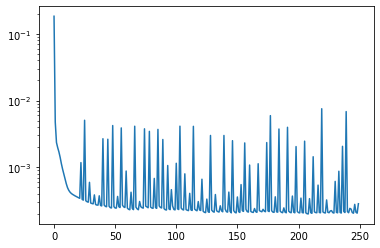

In [26]:
plt.plot(test)
plt.yscale('log')

## Let's do a longer run with a lower learning rate

In [27]:
assert xs_train.dtype == dtype
assert ys_train.dtype == dtype
assert xs_test.dtype == dtype
assert ys_test.dtype == dtype

if activation == 'ReLU':
    activation_fn = nn.ReLU
elif activation == 'Tanh':
    activation_fn = nn.Tanh
elif activation == 'Sigmoid':
    activation_fn = nn.Sigmoid
else:
    assert False, f"Unrecognized activation function identifier: {activation}"

# create model
layers2 = []
for i in range(depth):
    if i == 0:
        layers2.append(nn.Linear(dimension, width))
        layers2.append(activation_fn())
    elif i == depth - 1:
        layers2.append(nn.Linear(width, 1))
    else:
        layers2.append(nn.Linear(width, width))
        layers2.append(activation_fn())
mlp2 = nn.Sequential(*layers2).to(device)
# _log.debug("Created model.")
# _log.debug(f"Model has {sum(t.numel() for t in mlp2.parameters())} parameters") 

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(mlp2.parameters(), lr=1e-4)

# ex.info['train'] = list()
train2 = list()
# ex.info['test'] = list()
test2 = list()
min_train2 = float('inf')
min_test2 = float('inf')
test_at_min_train2 = float('inf')

k = 0
for step in tqdm(range(MAX_TRAIN_ITERS*3)):
    optim.zero_grad()
    if TRAIN_POINTS <= MAX_BATCH_SIZE:
        ys_pred = mlp2(xs_train)
        l = loss_fn(ys_train, ys_pred)
    else:
        sample_idx = torch.arange(k, k+MAX_BATCH_SIZE, 1) % TRAIN_POINTS
        xs_batch, ys_batch = xs_train[sample_idx], ys_train[sample_idx]
        ys_pred = mlp2(xs_batch)
        l = loss_fn(ys_batch, ys_pred)
        k += MAX_BATCH_SIZE
    l.backward()
    optim.step()
    with torch.no_grad():
        train_l = torch.sqrt(l).item()
        test_l = torch.sqrt(torch.mean(torch.pow(mlp2(xs_test) - ys_test, 2))).item()
        if train_l < min_train2:
            min_train2 = train_l
            test_at_min_train2 = test_l
        min_test = test_l if test_l < min_test else min_test
        if step % 100 == 0:
            # ex.info['train'].append(train_l)
            # ex.info['test'].append(test_l)
            train2.append(train_l)
            test2.append(test_l)
    # if step % (MAX_TRAIN_ITERS // 10) == 0:
    #     _log.debug("{:.0f}% done with training".format(step / MAX_TRAIN_ITERS * 100))
# ex.info['min_train'] = min_train
# ex.info['min_test'] = min_test
# ex.info['test_at_min_train'] = test_at_min_train
# _log.debug("Test loss: {:.3e}".format(test_at_min_train))


  0%|          | 0/75000 [00:00<?, ?it/s]

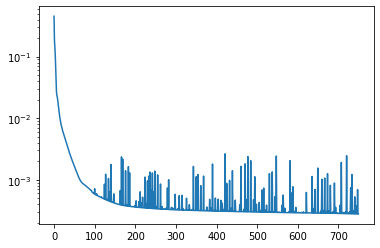

In [31]:
plt.plot(test2)
plt.yscale('log')

In [32]:
test_at_min_train

0.00020518755942106246

In [33]:
test_at_min_train2

0.0002793481954254736

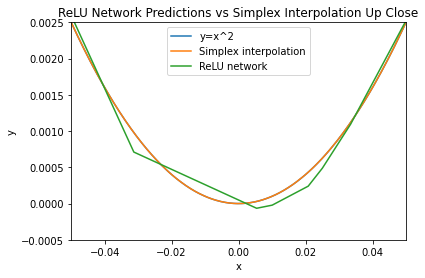

In [106]:
xl = 0.05
xs_plots = np.linspace(-xl, xl, 100000).reshape((100000, 1))
xs_plots = torch.from_numpy(xs_plots).to(device)
ys_network = mlp(xs_plots)
ys_simplex = f(xs_plots.detach().cpu().numpy())

plt.plot(xs_plots.detach().cpu().numpy(), xs_plots.detach().cpu().numpy() ** 2, label="y=x^2")
plt.plot(xs_plots.detach().cpu().numpy(), ys_simplex, label="Simplex interpolation")
plt.plot(xs_plots.detach().cpu().numpy(), ys_network.detach().cpu().numpy(), label="ReLU network")


plt.xlim(-xl, xl)
plt.ylim(-0.01*xl, xl**2)
plt.legend()

plt.title("ReLU Network Predictions vs Simplex Interpolation Up Close")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("figures/1d-network-visualizing-fit-large-regions.jpg", dpi=200)

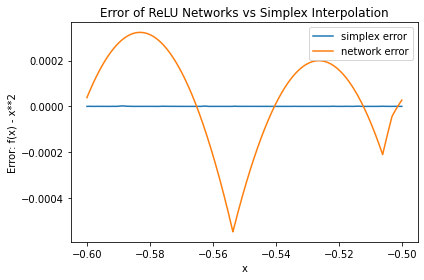

In [105]:
xs_plots = np.linspace(-0.5, -0.6, 100000).reshape((100000, 1))
xs_plots = torch.from_numpy(xs_plots).to(device)
ys_network = mlp(xs_plots)
ys_simplex = f(xs_plots.detach().cpu().numpy())
simplex_error = ys_simplex - (xs_plots.detach().cpu().numpy() ** 2)
network_error = ys_network - (xs_plots **2)

# plt.plot(xs_plots.detach().cpu().numpy(), xs_plots.detach().cpu().numpy() ** 2, label="y=x^2")
# plt.plot(xs_plots.detach().cpu().numpy(), ys_simplex, label="Simplex interpolation")
# plt.plot(xs_plots.detach().cpu().numpy(), ys_network.detach().cpu().numpy(), label="ReLU network")
plt.plot(xs_plots.detach().cpu().numpy(), simplex_error, label="simplex error")
plt.plot(xs_plots.detach().cpu().numpy(), network_error.detach().cpu().numpy(), label="network error")

# plt.xlim(-0.502, -0.5019)
# plt.ylim(0.5019**2*0.99999, 0.502**2*1.00001)
# plt.ylim(-0.01*xl, xl**2)
plt.legend()

plt.title("Error of ReLU Networks vs Simplex Interpolation")
plt.xlabel("x")
plt.ylabel("Error: f(x) - x**2")
plt.tight_layout()
plt.savefig("figures/1d-simplex-and-network-interpolation-error.jpg", dpi=200)

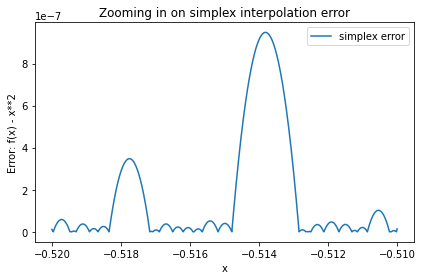

In [104]:
xs_plots = np.linspace(-0.51, -0.52, 100000).reshape((100000, 1))
xs_plots = torch.from_numpy(xs_plots).to(device)
ys_network = mlp(xs_plots)
ys_simplex = f(xs_plots.detach().cpu().numpy())
simplex_error = ys_simplex - (xs_plots.detach().cpu().numpy() ** 2)
network_error = ys_network - (xs_plots **2)

# plt.plot(xs_plots.detach().cpu().numpy(), xs_plots.detach().cpu().numpy() ** 2, label="y=x^2")
# plt.plot(xs_plots.detach().cpu().numpy(), ys_simplex, label="Simplex interpolation")
# plt.plot(xs_plots.detach().cpu().numpy(), ys_network.detach().cpu().numpy(), label="ReLU network")
plt.plot(xs_plots.detach().cpu().numpy(), simplex_error, label="simplex error")
# plt.plot(xs_plots.detach().cpu().numpy(), network_error.detach().cpu().numpy(), label="network error")

# plt.xlim(-0.502, -0.5019)
# plt.ylim(0.5019**2*0.99999, 0.502**2*1.00001)
# plt.ylim(-0.01*xl, xl**2)
plt.legend()

plt.title("Zooming in on simplex interpolation error")
plt.xlabel("x")
plt.ylabel("Error: f(x) - x**2")
plt.tight_layout()
plt.savefig("figures/1d-simplex-interpolation-error.jpg", dpi=200)

# Run with lower TRAIN_POINTS

In [21]:
eqn = 'Z.001'
width = 8
depth = 3
lr = 1e-3
activation = 'ReLU'
N_TEST_POINTS = 30000
TEST_COMPACTIFICATION = 0.8
MAX_TRAIN_ITERS = 25000
MAX_BATCH_SIZE = 30000
spreadsheet = "../equations.csv"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 0

In [22]:
torch.set_default_dtype(dtype)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [23]:
device

device(type='cuda', index=0)

In [24]:
equations = pd.read_csv(spreadsheet)
row = equations[equations['Equation'] == eqn].iloc[0]
dimension = int(row['# variables'])
formula = row['Formula']
variables = [row[f'v{i}_name'] for i in range(1, dimension+1)]
ranges = [(row[f'v{i}_low'], row[f'v{i}_high']) for i in range(1, dimension+1)]
target = lambdify(variables, parse_expr(formula))


TRAIN_POINTS = parameters(width, depth, dimension) // (dimension + 1)
# ex.info['TRAIN_POINTS'] = TRAIN_POINTS
# _log.debug(f"TRAIN_POINTS: {TRAIN_POINTS}")

# create datasets
ls = np.array([ranges[i][0] for i in range(dimension)])
hs = np.array([ranges[i][1] for i in range(dimension)])
xs_train = np.random.uniform(low=ls, high=hs, size=(TRAIN_POINTS, dimension))
ys_train = target(*[xs_train[:, i] for i in range(dimension)])

cs = (hs + ls) / 2
ws = (hs - ls) * TEST_COMPACTIFICATION
ls, hs = cs - ws / 2, cs + ws / 2
xs_test = np.random.uniform(low=ls, high=hs, size=(N_TEST_POINTS, dimension))
ys_test = target(*[xs_test[:, i] for i in range(dimension)])

xs_train = torch.from_numpy(xs_train).to(device)
ys_train = torch.from_numpy(ys_train).to(device).unsqueeze(dim=1)
xs_test = torch.from_numpy(xs_test).to(device)
ys_test = torch.from_numpy(ys_test).to(device).unsqueeze(dim=1)

In [25]:
## Simplex interpolation first

from scipy import spatial, interpolate

# xs_train = xs_train.reshape((TRAIN_POINTS,))
# ys_train = ys_train.reshape((TRAIN_POINTS,))
# xs_test = xs_test.reshape((N_TEST_POINTS,))
# ys_test = ys_test.reshape((N_TEST_POINTS,))

f = interpolate.interp1d(xs_train.reshape((TRAIN_POINTS,)).cpu().detach().cpu().numpy(), ys_train.reshape((TRAIN_POINTS,)).detach().cpu().numpy(), kind='linear', bounds_error=False)

# _log.debug("Evaluating model") 
preds = f(xs_test.reshape((N_TEST_POINTS,)).detach().cpu().numpy())
valid_idx = ~np.isnan(preds)
rmse_loss = np.sqrt(np.mean(np.power(preds[valid_idx] - ys_test.reshape((N_TEST_POINTS,)).detach().cpu().numpy()[valid_idx], 2)))
# ex.info['test'] = rmse_loss.item() 

In [26]:
assert xs_train.dtype == dtype
assert ys_train.dtype == dtype
assert xs_test.dtype == dtype
assert ys_test.dtype == dtype

if activation == 'ReLU':
    activation_fn = nn.ReLU
elif activation == 'Tanh':
    activation_fn = nn.Tanh
elif activation == 'Sigmoid':
    activation_fn = nn.Sigmoid
else:
    assert False, f"Unrecognized activation function identifier: {activation}"

# create model
layers = []
for i in range(depth):
    if i == 0:
        layers.append(nn.Linear(dimension, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        layers.append(nn.Linear(width, 1))
    else:
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())
mlp = nn.Sequential(*layers).to(device)
# _log.debug("Created model.")
# _log.debug(f"Model has {sum(t.numel() for t in mlp.parameters())} parameters") 

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(mlp.parameters(), lr=lr)

# ex.info['train'] = list()
train = list()
# ex.info['test'] = list()
test = list()
min_train = float('inf')
min_test = float('inf')
test_at_min_train = float('inf')

k = 0
for step in tqdm(range(MAX_TRAIN_ITERS)):
    optim.zero_grad()
    if TRAIN_POINTS <= MAX_BATCH_SIZE:
        ys_pred = mlp(xs_train)
        l = loss_fn(ys_train, ys_pred)
    else:
        sample_idx = torch.arange(k, k+MAX_BATCH_SIZE, 1) % TRAIN_POINTS
        xs_batch, ys_batch = xs_train[sample_idx], ys_train[sample_idx]
        ys_pred = mlp(xs_batch)
        l = loss_fn(ys_batch, ys_pred)
        k += MAX_BATCH_SIZE
    l.backward()
    optim.step()
    with torch.no_grad():
        train_l = torch.sqrt(l).item()
        test_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_test) - ys_test, 2))).item()
        if train_l < min_train:
            min_train = train_l
            test_at_min_train = test_l
        min_test = test_l if test_l < min_test else min_test
        if step % 100 == 0:
            # ex.info['train'].append(train_l)
            # ex.info['test'].append(test_l)
            train.append(train_l)
            test.append(test_l)
    # if step % (MAX_TRAIN_ITERS // 10) == 0:
    #     _log.debug("{:.0f}% done with training".format(step / MAX_TRAIN_ITERS * 100))
# ex.info['min_train'] = min_train
# ex.info['min_test'] = min_test
# ex.info['test_at_min_train'] = test_at_min_train
# _log.debug("Test loss: {:.3e}".format(test_at_min_train))


  0%|          | 0/25000 [00:00<?, ?it/s]

### figures

In [13]:
import matplotlib.pyplot as plt

In [30]:
xs_train.shape

torch.Size([48, 1])

Text(0, 0.5, '$y = x^2$')

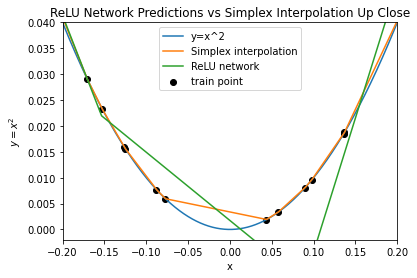

In [35]:
xl = 0.2
xs_plots = np.linspace(-xl, xl, 100000).reshape((100000, 1))
xs_plots = torch.from_numpy(xs_plots).to(device)
ys_network = mlp(xs_plots)
ys_simplex = f(xs_plots.detach().cpu().numpy())

plt.plot(xs_plots.detach().cpu().numpy(), xs_plots.detach().cpu().numpy() ** 2, label="y=x^2")
plt.plot(xs_plots.detach().cpu().numpy(), ys_simplex, label="Simplex interpolation")
plt.plot(xs_plots.detach().cpu().numpy(), ys_network.detach().cpu().numpy(), label="ReLU network")
plt.scatter(xs_train.detach().cpu().numpy(), xs_train.detach().cpu().numpy() ** 2, color='black', label='train point')

plt.xlim(-xl, xl)
plt.ylim(-0.01*xl, xl**2)
plt.legend()

plt.title("ReLU Network Predictions vs Simplex Interpolation Up Close")
plt.xlabel("x")
plt.ylabel(r"$y = x^2$")
# plt.savefig("figures/1d-network-visualizing-fit-large-regions.jpg", dpi=200)

In [43]:
eqn = 'Z.001'
width = 30
depth = 2
lr = 1e-3
activation = 'ReLU'
N_TEST_POINTS = 30000
TEST_COMPACTIFICATION = 0.8
MAX_TRAIN_ITERS = 25000
MAX_BATCH_SIZE = 30000
spreadsheet = "../equations.csv"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 0

In [44]:
torch.set_default_dtype(dtype)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [45]:
device

device(type='cuda', index=0)

In [46]:
equations = pd.read_csv(spreadsheet)
row = equations[equations['Equation'] == eqn].iloc[0]
dimension = int(row['# variables'])
formula = row['Formula']
variables = [row[f'v{i}_name'] for i in range(1, dimension+1)]
ranges = [(row[f'v{i}_low'], row[f'v{i}_high']) for i in range(1, dimension+1)]
target = lambdify(variables, parse_expr(formula))


TRAIN_POINTS = parameters(width, depth, dimension) // (dimension + 1)
# ex.info['TRAIN_POINTS'] = TRAIN_POINTS
# _log.debug(f"TRAIN_POINTS: {TRAIN_POINTS}")

# create datasets
ls = np.array([ranges[i][0] for i in range(dimension)])
hs = np.array([ranges[i][1] for i in range(dimension)])
xs_train = np.random.uniform(low=ls, high=hs, size=(TRAIN_POINTS, dimension))
ys_train = target(*[xs_train[:, i] for i in range(dimension)])

cs = (hs + ls) / 2
ws = (hs - ls) * TEST_COMPACTIFICATION
ls, hs = cs - ws / 2, cs + ws / 2
xs_test = np.random.uniform(low=ls, high=hs, size=(N_TEST_POINTS, dimension))
ys_test = target(*[xs_test[:, i] for i in range(dimension)])

xs_train = torch.from_numpy(xs_train).to(device)
ys_train = torch.from_numpy(ys_train).to(device).unsqueeze(dim=1)
xs_test = torch.from_numpy(xs_test).to(device)
ys_test = torch.from_numpy(ys_test).to(device).unsqueeze(dim=1)

In [47]:
## Simplex interpolation first

from scipy import spatial, interpolate

# xs_train = xs_train.reshape((TRAIN_POINTS,))
# ys_train = ys_train.reshape((TRAIN_POINTS,))
# xs_test = xs_test.reshape((N_TEST_POINTS,))
# ys_test = ys_test.reshape((N_TEST_POINTS,))

f = interpolate.interp1d(xs_train.reshape((TRAIN_POINTS,)).cpu().detach().cpu().numpy(), ys_train.reshape((TRAIN_POINTS,)).detach().cpu().numpy(), kind='linear', bounds_error=False)

# _log.debug("Evaluating model") 
preds = f(xs_test.reshape((N_TEST_POINTS,)).detach().cpu().numpy())
valid_idx = ~np.isnan(preds)
rmse_loss = np.sqrt(np.mean(np.power(preds[valid_idx] - ys_test.reshape((N_TEST_POINTS,)).detach().cpu().numpy()[valid_idx], 2)))
# ex.info['test'] = rmse_loss.item() 

In [48]:
assert xs_train.dtype == dtype
assert ys_train.dtype == dtype
assert xs_test.dtype == dtype
assert ys_test.dtype == dtype

if activation == 'ReLU':
    activation_fn = nn.ReLU
elif activation == 'Tanh':
    activation_fn = nn.Tanh
elif activation == 'Sigmoid':
    activation_fn = nn.Sigmoid
else:
    assert False, f"Unrecognized activation function identifier: {activation}"

# create model
layers = []
for i in range(depth):
    if i == 0:
        layers.append(nn.Linear(dimension, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        layers.append(nn.Linear(width, 1))
    else:
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())
mlp = nn.Sequential(*layers).to(device)
# _log.debug("Created model.")
# _log.debug(f"Model has {sum(t.numel() for t in mlp.parameters())} parameters") 

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(mlp.parameters(), lr=lr)

# ex.info['train'] = list()
train = list()
# ex.info['test'] = list()
test = list()
min_train = float('inf')
min_test = float('inf')
test_at_min_train = float('inf')

k = 0
for step in tqdm(range(MAX_TRAIN_ITERS)):
    optim.zero_grad()
    if TRAIN_POINTS <= MAX_BATCH_SIZE:
        ys_pred = mlp(xs_train)
        l = loss_fn(ys_train, ys_pred)
    else:
        sample_idx = torch.arange(k, k+MAX_BATCH_SIZE, 1) % TRAIN_POINTS
        xs_batch, ys_batch = xs_train[sample_idx], ys_train[sample_idx]
        ys_pred = mlp(xs_batch)
        l = loss_fn(ys_batch, ys_pred)
        k += MAX_BATCH_SIZE
    l.backward()
    optim.step()
    with torch.no_grad():
        train_l = torch.sqrt(l).item()
        test_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_test) - ys_test, 2))).item()
        if train_l < min_train:
            min_train = train_l
            test_at_min_train = test_l
        min_test = test_l if test_l < min_test else min_test
        if step % 100 == 0:
            # ex.info['train'].append(train_l)
            # ex.info['test'].append(test_l)
            train.append(train_l)
            test.append(test_l)
    # if step % (MAX_TRAIN_ITERS // 10) == 0:
    #     _log.debug("{:.0f}% done with training".format(step / MAX_TRAIN_ITERS * 100))
# ex.info['min_train'] = min_train
# ex.info['min_test'] = min_test
# ex.info['test_at_min_train'] = test_at_min_train
# _log.debug("Test loss: {:.3e}".format(test_at_min_train))


  0%|          | 0/25000 [00:00<?, ?it/s]

### figures

In [49]:
import matplotlib.pyplot as plt

Text(0, 0.5, '$y = x^2$')

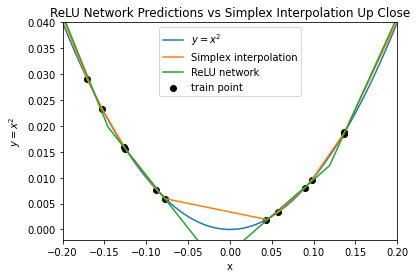

In [50]:
xl = 0.2
xs_plots = np.linspace(-xl, xl, 100000).reshape((100000, 1))
xs_plots = torch.from_numpy(xs_plots).to(device)
ys_network = mlp(xs_plots)
ys_simplex = f(xs_plots.detach().cpu().numpy())

plt.plot(xs_plots.detach().cpu().numpy(), xs_plots.detach().cpu().numpy() ** 2, label=r"$y=x^2$")
plt.plot(xs_plots.detach().cpu().numpy(), ys_simplex, label="Simplex interpolation")
plt.plot(xs_plots.detach().cpu().numpy(), ys_network.detach().cpu().numpy(), label="ReLU network")
plt.scatter(xs_train.detach().cpu().numpy(), xs_train.detach().cpu().numpy() ** 2, color='black', label='train point')

plt.xlim(-xl, xl)
plt.ylim(-0.01*xl, xl**2)
plt.legend()

plt.title("ReLU Network Predictions vs Simplex Interpolation Up Close")
plt.xlabel("x")
plt.ylabel(r"$y = x^2$")
# plt.savefig("figures/1d-network-visualizing-fit-large-regions.jpg", dpi=200)

In [68]:
eqn = 'Z.001'
# width = 30
# depth = 2
lr = 1e-3
activation = 'ReLU'
N_TEST_POINTS = 30000
TEST_COMPACTIFICATION = 0.8
MAX_TRAIN_ITERS = 25000
MAX_BATCH_SIZE = 30000
spreadsheet = "../equations.csv"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 0

depths = [2, 3, 4]
widths = [30, 8, 6]

results = dict()
for depth, width in zip(depths, widths):
    torch.set_default_dtype(dtype)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    equations = pd.read_csv(spreadsheet)
    row = equations[equations['Equation'] == eqn].iloc[0]
    dimension = int(row['# variables'])
    formula = row['Formula']
    variables = [row[f'v{i}_name'] for i in range(1, dimension+1)]
    ranges = [(row[f'v{i}_low'], row[f'v{i}_high']) for i in range(1, dimension+1)]
    target = lambdify(variables, parse_expr(formula))

    TRAIN_POINTS = parameters(width, depth, dimension) // (dimension + 1)
    # ex.info['TRAIN_POINTS'] = TRAIN_POINTS
    # _log.debug(f"TRAIN_POINTS: {TRAIN_POINTS}")

    # create datasets
    ls = np.array([ranges[i][0] for i in range(dimension)])
    hs = np.array([ranges[i][1] for i in range(dimension)])
    xs_train = np.random.uniform(low=ls, high=hs, size=(TRAIN_POINTS, dimension))
    ys_train = target(*[xs_train[:, i] for i in range(dimension)])

    cs = (hs + ls) / 2
    ws = (hs - ls) * TEST_COMPACTIFICATION
    ls, hs = cs - ws / 2, cs + ws / 2
    xs_test = np.random.uniform(low=ls, high=hs, size=(N_TEST_POINTS, dimension))
    ys_test = target(*[xs_test[:, i] for i in range(dimension)])

    xs_train = torch.from_numpy(xs_train).to(device)
    ys_train = torch.from_numpy(ys_train).to(device).unsqueeze(dim=1)
    xs_test = torch.from_numpy(xs_test).to(device)
    ys_test = torch.from_numpy(ys_test).to(device).unsqueeze(dim=1)
    
    ## Simplex interpolation first

    from scipy import spatial, interpolate

    # xs_train = xs_train.reshape((TRAIN_POINTS,))
    # ys_train = ys_train.reshape((TRAIN_POINTS,))
    # xs_test = xs_test.reshape((N_TEST_POINTS,))
    # ys_test = ys_test.reshape((N_TEST_POINTS,))

    f = interpolate.interp1d(xs_train.reshape((TRAIN_POINTS,)).cpu().detach().cpu().numpy(), ys_train.reshape((TRAIN_POINTS,)).detach().cpu().numpy(), kind='linear', bounds_error=False)

    # _log.debug("Evaluating model") 
    preds = f(xs_test.reshape((N_TEST_POINTS,)).detach().cpu().numpy())
    valid_idx = ~np.isnan(preds)
    rmse_loss = np.sqrt(np.mean(np.power(preds[valid_idx] - ys_test.reshape((N_TEST_POINTS,)).detach().cpu().numpy()[valid_idx], 2)))
    # ex.info['test'] = rmse_loss.item() 

    if activation == 'ReLU':
        activation_fn = nn.ReLU
    elif activation == 'Tanh':
        activation_fn = nn.Tanh
    elif activation == 'Sigmoid':
        activation_fn = nn.Sigmoid
    else:
        assert False, f"Unrecognized activation function identifier: {activation}"

    # create model
    layers = []
    for i in range(depth):
        if i == 0:
            layers.append(nn.Linear(dimension, width))
            layers.append(activation_fn())
        elif i == depth - 1:
            layers.append(nn.Linear(width, 1))
        else:
            layers.append(nn.Linear(width, width))
            layers.append(activation_fn())
    mlp = nn.Sequential(*layers).to(device)
    # _log.debug("Created model.")
    # _log.debug(f"Model has {sum(t.numel() for t in mlp.parameters())} parameters") 

    loss_fn = nn.MSELoss()
    optim = torch.optim.Adam(mlp.parameters(), lr=lr)

    # ex.info['train'] = list()
    train = list()
    # ex.info['test'] = list()
    test = list()
    min_train = float('inf')
    min_test = float('inf')
    test_at_min_train = float('inf')

    k = 0
    for step in tqdm(range(MAX_TRAIN_ITERS)):
        optim.zero_grad()
        if TRAIN_POINTS <= MAX_BATCH_SIZE:
            ys_pred = mlp(xs_train)
            l = loss_fn(ys_train, ys_pred)
        else:
            sample_idx = torch.arange(k, k+MAX_BATCH_SIZE, 1) % TRAIN_POINTS
            xs_batch, ys_batch = xs_train[sample_idx], ys_train[sample_idx]
            ys_pred = mlp(xs_batch)
            l = loss_fn(ys_batch, ys_pred)
            k += MAX_BATCH_SIZE
        l.backward()
        optim.step()
        with torch.no_grad():
            train_l = torch.sqrt(l).item()
            test_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_test) - ys_test, 2))).item()
            if train_l < min_train:
                min_train = train_l
                test_at_min_train = test_l
            min_test = test_l if test_l < min_test else min_test
            if step % 100 == 0:
                # ex.info['train'].append(train_l)
                # ex.info['test'].append(test_l)
                train.append(train_l)
                test.append(test_l)
    
    results[depth] = dict()
    results[depth]['test_at_min_train'] = test_at_min_train
    results[depth]['test'] = test
    results[depth]['train'] = train
    results[depth]['mlp'] = mlp
    results[depth]['f'] = f

    

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

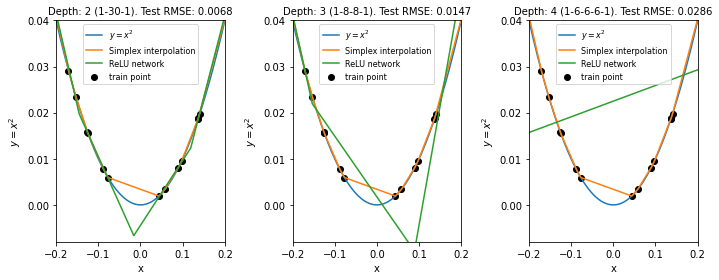

In [90]:
plt.figure(figsize=(10, 4))

for i, (depth, width) in enumerate(zip(depths, widths)):
    plt.subplot(1, 3, i+1)

    xl = 0.2
    xs_plots = np.linspace(-xl, xl, 100000).reshape((100000, 1))
    xs_plots = torch.from_numpy(xs_plots).to(device)
    ys_network = results[depth]['mlp'](xs_plots)
    ys_simplex = results[depth]['f'](xs_plots.detach().cpu().numpy())

    plt.plot(xs_plots.detach().cpu().numpy(), xs_plots.detach().cpu().numpy() ** 2, label=r"$y=x^2$")
    plt.plot(xs_plots.detach().cpu().numpy(), ys_simplex, label="Simplex interpolation")
    plt.plot(xs_plots.detach().cpu().numpy(), ys_network.detach().cpu().numpy(), label="ReLU network")
    plt.scatter(xs_train.detach().cpu().numpy(), xs_train.detach().cpu().numpy() ** 2, color='black', label='train point')

    plt.xlim(-xl, xl)
    plt.ylim(-0.04*xl, xl**2)
    plt.legend(prop={'size': 8})

    plt.title(f"Depth: {depth} (1-{(str(width)+'-')*(depth-1)}1). Test RMSE: {results[depth]['test_at_min_train']:.4f}", fontsize=10)
    plt.xlabel("x")
    plt.ylabel(r"$y = x^2$")

plt.tight_layout()
plt.savefig("figures/1d-network-visualizing-fit-3-depths.pdf")

# zero bias initialization

In [92]:
eqn = 'Z.001'
# width = 30
# depth = 2
lr = 1e-3
activation = 'ReLU'
N_TEST_POINTS = 30000
TEST_COMPACTIFICATION = 0.8
MAX_TRAIN_ITERS = 25000
MAX_BATCH_SIZE = 30000
spreadsheet = "../equations.csv"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 0

depths = [2, 3, 4]
widths = [30, 8, 6]

results = dict()
for depth, width in zip(depths, widths):
    torch.set_default_dtype(dtype)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    equations = pd.read_csv(spreadsheet)
    row = equations[equations['Equation'] == eqn].iloc[0]
    dimension = int(row['# variables'])
    formula = row['Formula']
    variables = [row[f'v{i}_name'] for i in range(1, dimension+1)]
    ranges = [(row[f'v{i}_low'], row[f'v{i}_high']) for i in range(1, dimension+1)]
    target = lambdify(variables, parse_expr(formula))

    TRAIN_POINTS = parameters(width, depth, dimension) // (dimension + 1)
    # ex.info['TRAIN_POINTS'] = TRAIN_POINTS
    # _log.debug(f"TRAIN_POINTS: {TRAIN_POINTS}")

    # create datasets
    ls = np.array([ranges[i][0] for i in range(dimension)])
    hs = np.array([ranges[i][1] for i in range(dimension)])
    xs_train = np.random.uniform(low=ls, high=hs, size=(TRAIN_POINTS, dimension))
    ys_train = target(*[xs_train[:, i] for i in range(dimension)])

    cs = (hs + ls) / 2
    ws = (hs - ls) * TEST_COMPACTIFICATION
    ls, hs = cs - ws / 2, cs + ws / 2
    xs_test = np.random.uniform(low=ls, high=hs, size=(N_TEST_POINTS, dimension))
    ys_test = target(*[xs_test[:, i] for i in range(dimension)])

    xs_train = torch.from_numpy(xs_train).to(device)
    ys_train = torch.from_numpy(ys_train).to(device).unsqueeze(dim=1)
    xs_test = torch.from_numpy(xs_test).to(device)
    ys_test = torch.from_numpy(ys_test).to(device).unsqueeze(dim=1)
    
    ## Simplex interpolation first

    from scipy import spatial, interpolate

    # xs_train = xs_train.reshape((TRAIN_POINTS,))
    # ys_train = ys_train.reshape((TRAIN_POINTS,))
    # xs_test = xs_test.reshape((N_TEST_POINTS,))
    # ys_test = ys_test.reshape((N_TEST_POINTS,))

    f = interpolate.interp1d(xs_train.reshape((TRAIN_POINTS,)).cpu().detach().cpu().numpy(), ys_train.reshape((TRAIN_POINTS,)).detach().cpu().numpy(), kind='linear', bounds_error=False)

    # _log.debug("Evaluating model") 
    preds = f(xs_test.reshape((N_TEST_POINTS,)).detach().cpu().numpy())
    valid_idx = ~np.isnan(preds)
    rmse_loss = np.sqrt(np.mean(np.power(preds[valid_idx] - ys_test.reshape((N_TEST_POINTS,)).detach().cpu().numpy()[valid_idx], 2)))
    # ex.info['test'] = rmse_loss.item() 

    if activation == 'ReLU':
        activation_fn = nn.ReLU
    elif activation == 'Tanh':
        activation_fn = nn.Tanh
    elif activation == 'Sigmoid':
        activation_fn = nn.Sigmoid
    else:
        assert False, f"Unrecognized activation function identifier: {activation}"

    # create model
    layers = []
    for i in range(depth):
        if i == 0:
            layers.append(nn.Linear(dimension, width))
            layers.append(activation_fn())
        elif i == depth - 1:
            layers.append(nn.Linear(width, 1))
        else:
            layers.append(nn.Linear(width, width))
            layers.append(activation_fn())
    mlp = nn.Sequential(*layers).to(device)
    for layer in mlp:
        if type(layer) is nn.Linear:
            layer.bias.data = torch.zeros(layer.bias.shape).to(device)
    
    # _log.debug("Created model.")
    # _log.debug(f"Model has {sum(t.numel() for t in mlp.parameters())} parameters") 

    loss_fn = nn.MSELoss()
    optim = torch.optim.Adam(mlp.parameters(), lr=lr)

    # ex.info['train'] = list()
    train = list()
    # ex.info['test'] = list()
    test = list()
    min_train = float('inf')
    min_test = float('inf')
    test_at_min_train = float('inf')

    k = 0
    for step in tqdm(range(MAX_TRAIN_ITERS)):
        optim.zero_grad()
        if TRAIN_POINTS <= MAX_BATCH_SIZE:
            ys_pred = mlp(xs_train)
            l = loss_fn(ys_train, ys_pred)
        else:
            sample_idx = torch.arange(k, k+MAX_BATCH_SIZE, 1) % TRAIN_POINTS
            xs_batch, ys_batch = xs_train[sample_idx], ys_train[sample_idx]
            ys_pred = mlp(xs_batch)
            l = loss_fn(ys_batch, ys_pred)
            k += MAX_BATCH_SIZE
        l.backward()
        optim.step()
        with torch.no_grad():
            train_l = torch.sqrt(l).item()
            test_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_test) - ys_test, 2))).item()
            if train_l < min_train:
                min_train = train_l
                test_at_min_train = test_l
            min_test = test_l if test_l < min_test else min_test
            if step % 100 == 0:
                # ex.info['train'].append(train_l)
                # ex.info['test'].append(test_l)
                train.append(train_l)
                test.append(test_l)
    
    results[depth] = dict()
    results[depth]['test_at_min_train'] = test_at_min_train
    results[depth]['test'] = test
    results[depth]['train'] = train
    results[depth]['mlp'] = mlp
    results[depth]['f'] = f

    

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

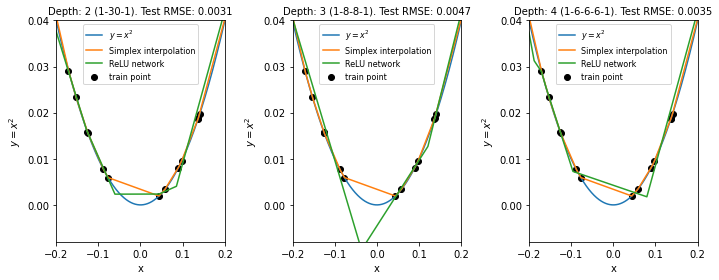

In [93]:
plt.figure(figsize=(10, 4))

for i, (depth, width) in enumerate(zip(depths, widths)):
    plt.subplot(1, 3, i+1)

    xl = 0.2
    xs_plots = np.linspace(-xl, xl, 100000).reshape((100000, 1))
    xs_plots = torch.from_numpy(xs_plots).to(device)
    ys_network = results[depth]['mlp'](xs_plots)
    ys_simplex = results[depth]['f'](xs_plots.detach().cpu().numpy())

    plt.plot(xs_plots.detach().cpu().numpy(), xs_plots.detach().cpu().numpy() ** 2, label=r"$y=x^2$")
    plt.plot(xs_plots.detach().cpu().numpy(), ys_simplex, label="Simplex interpolation")
    plt.plot(xs_plots.detach().cpu().numpy(), ys_network.detach().cpu().numpy(), label="ReLU network")
    plt.scatter(xs_train.detach().cpu().numpy(), xs_train.detach().cpu().numpy() ** 2, color='black', label='train point')

    plt.xlim(-xl, xl)
    plt.ylim(-0.04*xl, xl**2)
    plt.legend(prop={'size': 8})

    plt.title(f"Depth: {depth} (1-{(str(width)+'-')*(depth-1)}1). Test RMSE: {results[depth]['test_at_min_train']:.4f}", fontsize=10)
    plt.xlabel("x")
    plt.ylabel(r"$y = x^2$")

plt.tight_layout()
# plt.savefig("figures/1d-network-visualizing-fit-3-depths.pdf")



# 2d problems

In [735]:
eqn = 'Z.008'
width = 10
depth = 3
lr = 1e-3
activation = 'ReLU'
N_TEST_POINTS = 30000
TEST_COMPACTIFICATION = 0.8
MAX_TRAIN_ITERS = 25000
MAX_BATCH_SIZE = 30000
spreadsheet = "../equations.csv"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 0

In [736]:
torch.set_default_dtype(dtype)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [737]:
device

device(type='cuda', index=0)

In [738]:
equations = pd.read_csv(spreadsheet)
row = equations[equations['Equation'] == eqn].iloc[0]
dimension = int(row['# variables'])
formula = row['Formula']
variables = [row[f'v{i}_name'] for i in range(1, dimension+1)]
ranges = [(row[f'v{i}_low'], row[f'v{i}_high']) for i in range(1, dimension+1)]
target = lambdify(variables, parse_expr(formula))

In [739]:
TRAIN_POINTS = parameters(width, depth, dimension) // (dimension + 1)
# ex.info['TRAIN_POINTS'] = TRAIN_POINTS
# _log.debug(f"TRAIN_POINTS: {TRAIN_POINTS}")

# create datasets
ls = np.array([ranges[i][0] for i in range(dimension)])
hs = np.array([ranges[i][1] for i in range(dimension)])
xs_train = np.random.uniform(low=ls, high=hs, size=(TRAIN_POINTS, dimension))
ys_train = target(*[xs_train[:, i] for i in range(dimension)])

cs = (hs + ls) / 2
ws = (hs - ls) * TEST_COMPACTIFICATION
ls, hs = cs - ws / 2, cs + ws / 2
xs_test = np.random.uniform(low=ls, high=hs, size=(N_TEST_POINTS, dimension))
ys_test = target(*[xs_test[:, i] for i in range(dimension)])

xs_train = torch.from_numpy(xs_train).to(device)
ys_train = torch.from_numpy(ys_train).to(device).unsqueeze(dim=1)
xs_test = torch.from_numpy(xs_test).to(device)
ys_test = torch.from_numpy(ys_test).to(device).unsqueeze(dim=1)

In [740]:
ys_test.shape

torch.Size([30000, 1])

In [741]:
## Simplex interpolation first

from scipy import spatial, interpolate

tri = spatial.Delaunay(xs_train.detach().cpu().numpy())
f = interpolate.LinearNDInterpolator(tri, ys_train.detach().cpu().numpy())

# _log.debug("Evaluating model")
preds = f(xs_test.detach().cpu().numpy())
valid_idx = ~np.isnan(preds)
rmse_loss = np.sqrt(np.mean(np.power(preds[valid_idx] - ys_test.detach().cpu().numpy()[valid_idx], 2)))

In [742]:
assert xs_train.dtype == dtype
assert ys_train.dtype == dtype
assert xs_test.dtype == dtype
assert ys_test.dtype == dtype

if activation == 'ReLU':
    activation_fn = nn.ReLU
elif activation == 'Tanh':
    activation_fn = nn.Tanh
elif activation == 'Sigmoid':
    activation_fn = nn.Sigmoid
else:
    assert False, f"Unrecognized activation function identifier: {activation}"

# create model
layers = []
for i in range(depth):
    if i == 0:
        layers.append(nn.Linear(dimension, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        layers.append(nn.Linear(width, 1))
    else:
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())
mlp = nn.Sequential(*layers).to(device)
# _log.debug("Created model.")
# _log.debug(f"Model has {sum(t.numel() for t in mlp.parameters())} parameters") 

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(mlp.parameters(), lr=lr)

# ex.info['train'] = list()
train = list()
# ex.info['test'] = list()
test = list()
min_train = float('inf')
min_test = float('inf')
test_at_min_train = float('inf')

k = 0
for step in tqdm(range(MAX_TRAIN_ITERS)):
    optim.zero_grad()
    if TRAIN_POINTS <= MAX_BATCH_SIZE:
        ys_pred = mlp(xs_train)
        l = loss_fn(ys_train, ys_pred)
    else:
        sample_idx = torch.arange(k, k+MAX_BATCH_SIZE, 1) % TRAIN_POINTS
        xs_batch, ys_batch = xs_train[sample_idx], ys_train[sample_idx]
        ys_pred = mlp(xs_batch)
        l = loss_fn(ys_batch, ys_pred)
        k += MAX_BATCH_SIZE
    l.backward()
    optim.step()
    with torch.no_grad():
        train_l = torch.sqrt(l).item()
        test_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_test) - ys_test, 2))).item()
        if train_l < min_train:
            min_train = train_l
            test_at_min_train = test_l
        min_test = test_l if test_l < min_test else min_test
        if step % 100 == 0:
            # ex.info['train'].append(train_l)
            # ex.info['test'].append(test_l)
            train.append(train_l)
            test.append(test_l)
    # if step % (MAX_TRAIN_ITERS // 10) == 0:
    #     _log.debug("{:.0f}% done with training".format(step / MAX_TRAIN_ITERS * 100))
# ex.info['min_train'] = min_train
# ex.info['min_test'] = min_test
# ex.info['test_at_min_train'] = test_at_min_train
# _log.debug("Test loss: {:.3e}".format(test_at_min_train))

  0%|          | 0/25000 [00:00<?, ?it/s]

In [758]:
N = 400
# xy = torch.meshgrid(torch.linspace(ranges[0][0], ranges[0][1], N, device=device), 
#                       torch.linspace(ranges[1][0], ranges[1][1], N, device=device), indexing='xy')
xy = torch.meshgrid(torch.linspace(-8, 8, N, device=device), 
                      torch.linspace(-8, 8, N, device=device), indexing='xy')
xs_grid = torch.cat([xy[0].flatten().unsqueeze(dim=1), xy[1].flatten().unsqueeze(dim=1)], dim=1)

In [759]:
jacobians = []
for i in tqdm(range(N**2)):
    jacobians.append(torch.autograd.functional.jacobian(mlp, inputs=xs_grid[i]).detach().cpu().numpy())
jacobians_py = [tuple(j.tolist()[0]) for j in jacobians]

  0%|          | 0/160000 [00:00<?, ?it/s]

In [763]:
jacobian_to_color = {jpy: matplotlib.cm.rainbow(np.random.rand())[:3] for jpy in set(jacobians_py)}

In [764]:
jacobians_grid = np.array(jacobians).reshape((N, N, 2))
shades = np.zeros((N, N, 3))
for i in range(N):
    for j in range(N):
        shades[i, j] = jacobian_to_color[tuple(jacobians_grid[i, j].tolist())]

Text(0.5, 1.0, 'ReLU network')

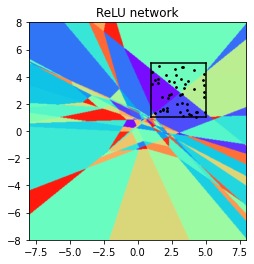

In [774]:
plt.imshow(shades, interpolation='bilinear', origin='lower', extent=[-8, 8, -8, 8])
plt.title(r"$f(x, y) = xy$")
plt.plot([1.0, 5.0], [1.0, 1.0], color='black')
plt.plot([5.0, 5.0], [1.0, 5.0], color='black')
plt.plot([1.0, 1.0], [1.0, 5.0], color='black')
plt.plot([1.0, 5.0], [5.0, 5.0], color='black')
plt.scatter(*zip(*xs_train.detach().cpu().numpy()), color='black', s=3)
# plt.ylim(ranges[0][0], ranges[0][1])
# plt.ylim(ranges[1][0], ranges[1][1])
plt.title("ReLU network")

Text(0.5, 1.0, 'ReLU network')

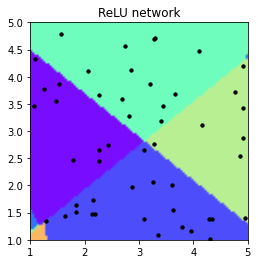

In [775]:
plt.imshow(shades, interpolation='bilinear', origin='lower', extent=[-8, 8, -8, 8])
plt.title(r"$f(x, y) = xy$")
plt.xlim(ranges[0][0], ranges[0][1])
plt.ylim(ranges[1][0], ranges[1][1])
plt.scatter(*zip(*xs_train.detach().cpu().numpy()), color='black', s=11)
plt.title("ReLU network")

(1.0, 5.0)

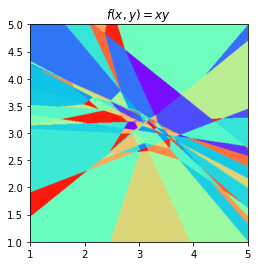

In [769]:
plt.imshow(shades, interpolation='bilinear', origin='lower', extent=[ranges[0][0], ranges[0][1], ranges[1][0], ranges[1][1]])
plt.title(r"$f(x, y) = xy$")
plt.xlim(ranges[0][0], ranges[0][1])
plt.ylim(ranges[1][0], ranges[1][1])
# plt.scatter(*zip(*xs_train.detach().cpu().numpy()), color='black', s=11)

### visualize the simplex solution

In [650]:
N = 100
xy = torch.meshgrid(torch.linspace(-1, 1, N, device=device), 
                      torch.linspace(-1, 1, N, device=device), indexing='ij')
xs_grid = torch.cat([xy[0].flatten().unsqueeze(dim=1), xy[1].flatten().unsqueeze(dim=1)], dim=1)

In [651]:
shades = np.zeros((N, N, 3))
for i in range(N):
    for j in range(N):
        x, y = xy[0][i, j].item(), xy[1][i, j].item()
#         xs_grid[i, j].detach().cpu().numpy()
        phi = np.arctan2(y, x)
        r = np.linalg.norm(np.array([x, y]), ord=2) / np.sqrt(2)
        shades[i, j] = matplotlib.colors.hsv_to_rgb([(phi + np.pi) / (2*np.pi), 1.0, r])

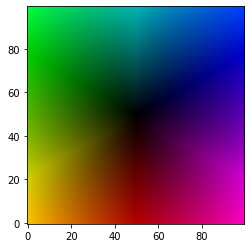

In [652]:
plt.imshow(shades, origin='lower')

In [653]:
def color_scheme(z, mag_norm=1.0):
    if np.any(np.isnan(z)):
        return np.nan * np.empty(3,)
    phi = np.arctan2(z[1], z[0])
    r = np.linalg.norm(z, ord=2)
    return matplotlib.colors.hsv_to_rgb([(phi + np.pi) / (2 * np.pi), 1., r / mag_norm])

In [753]:
N = 200
xy = torch.meshgrid(torch.linspace(ranges[0][0]+0.0, ranges[0][1]-0.0, N, device=device), 
                      torch.linspace(ranges[1][0]+0.0, ranges[1][1]-0.0, N, device=device), indexing='xy')
xs_grid = torch.cat([xy[0].flatten().unsqueeze(dim=1), xy[1].flatten().unsqueeze(dim=1)], dim=1)

In [754]:
jacobians = []
for i in tqdm(range(N**2)):
    x = xs_grid[i].detach().cpu().numpy()
    dx = 1e-8
    dfdx = (f(x + np.array([dx, 0.0])) - f(x)) / dx
    dfdy = (f(x + np.array([0.0, dx])) - f(x)) / dx
    jac = np.array([dfdx, dfdy]).flatten()
    jac = np.round(jac, 4)
    jacobians.append(jac)


jacobians_py = [tuple(jac.tolist()) for jac in jacobians]

# min_angle = 
jacobian_to_color = dict()
for jpy in set(jacobians_py):
    if np.any(np.isnan(jpy)):
        jacobian_to_color['nan'] = np.array([1., 1., 1.]) # white background
    else:
#         jacobian_to_color[jpy] = matplotlib.cm.gnuplot2((np.arctan2(jpy[1], jpy[0]) + np.pi)/(2*np.pi))[:-1]
        jacobian_to_color[jpy] = matplotlib.cm.rainbow(np.random.rand())[:-1]
    
# jacobian_to_color = {jpy: (1.0 if np.any(np.isnan(jpy)) else np.arctan2(jpy[0], jpy[1])) for jpy in set(jacobians_py)}

  0%|          | 0/40000 [00:00<?, ?it/s]

In [755]:
jacobians_grid = np.array(jacobians).reshape((N, N, 2))
max_jacobian_norm = np.nanmax(np.linalg.norm(jacobians_grid, ord=2, axis=2))

shades = np.zeros((N, N, 3))
for i in range(N):
    for j in range(N):
        if np.any(np.isnan(jacobians_grid[i, j])):
            shades[i, j] = jacobian_to_color['nan']
        else:
#             shades[i, j] = color_scheme(jacobians_grid[i, j], mag_norm=max_jacobian_norm)
            shades[i, j] = jacobian_to_color[tuple(jacobians_grid[i, j].tolist())]

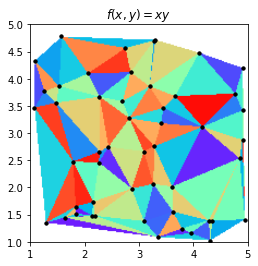

In [756]:
plt.imshow(shades, interpolation='bilinear', origin='lower', extent=[ranges[0][0], ranges[0][1], ranges[1][0], ranges[1][1]])
plt.title(r"$f(x, y) = xy$")
plt.ylim(ranges[0][0], ranges[0][1])
plt.ylim(ranges[1][0], ranges[1][1])
plt.scatter(*zip(*xs_train.detach().cpu().numpy()), color='black', s=11)

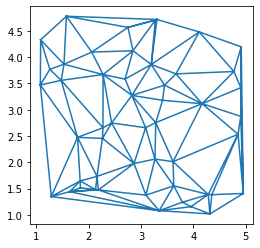

In [701]:
plt.figure(figsize=(4, 4))
plt.triplot(*zip(*xs_train.detach().cpu().numpy()), tri.simplices)

In [702]:
preds = f(xs_train.detach().cpu().numpy())
valid_idx = ~np.isnan(preds)
rmse_loss = np.sqrt(np.mean(np.power(preds[valid_idx] - ys_train.detach().cpu().numpy()[valid_idx], 2)))

## now a wider network (more data)

In [776]:
eqn = 'Z.008'
width = 40
depth = 3
lr = 1e-3
activation = 'ReLU'
N_TEST_POINTS = 30000
TEST_COMPACTIFICATION = 0.8
MAX_TRAIN_ITERS = 25000
MAX_BATCH_SIZE = 30000
spreadsheet = "../equations.csv"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 0

In [777]:
torch.set_default_dtype(dtype)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [778]:
device

device(type='cuda', index=0)

In [779]:
equations = pd.read_csv(spreadsheet)
row = equations[equations['Equation'] == eqn].iloc[0]
dimension = int(row['# variables'])
formula = row['Formula']
variables = [row[f'v{i}_name'] for i in range(1, dimension+1)]
ranges = [(row[f'v{i}_low'], row[f'v{i}_high']) for i in range(1, dimension+1)]
target = lambdify(variables, parse_expr(formula))

In [780]:
TRAIN_POINTS = parameters(width, depth, dimension) // (dimension + 1)
# ex.info['TRAIN_POINTS'] = TRAIN_POINTS
# _log.debug(f"TRAIN_POINTS: {TRAIN_POINTS}")

# create datasets
ls = np.array([ranges[i][0] for i in range(dimension)])
hs = np.array([ranges[i][1] for i in range(dimension)])
xs_train = np.random.uniform(low=ls, high=hs, size=(TRAIN_POINTS, dimension))
ys_train = target(*[xs_train[:, i] for i in range(dimension)])

cs = (hs + ls) / 2
ws = (hs - ls) * TEST_COMPACTIFICATION
ls, hs = cs - ws / 2, cs + ws / 2
xs_test = np.random.uniform(low=ls, high=hs, size=(N_TEST_POINTS, dimension))
ys_test = target(*[xs_test[:, i] for i in range(dimension)])

xs_train = torch.from_numpy(xs_train).to(device)
ys_train = torch.from_numpy(ys_train).to(device).unsqueeze(dim=1)
xs_test = torch.from_numpy(xs_test).to(device)
ys_test = torch.from_numpy(ys_test).to(device).unsqueeze(dim=1)

In [781]:
ys_test.shape

torch.Size([30000, 1])

In [782]:
## Simplex interpolation first

from scipy import spatial, interpolate

tri = spatial.Delaunay(xs_train.detach().cpu().numpy())
f = interpolate.LinearNDInterpolator(tri, ys_train.detach().cpu().numpy())

# _log.debug("Evaluating model")
preds = f(xs_test.detach().cpu().numpy())
valid_idx = ~np.isnan(preds)
rmse_loss = np.sqrt(np.mean(np.power(preds[valid_idx] - ys_test.detach().cpu().numpy()[valid_idx], 2)))

In [783]:
assert xs_train.dtype == dtype
assert ys_train.dtype == dtype
assert xs_test.dtype == dtype
assert ys_test.dtype == dtype

if activation == 'ReLU':
    activation_fn = nn.ReLU
elif activation == 'Tanh':
    activation_fn = nn.Tanh
elif activation == 'Sigmoid':
    activation_fn = nn.Sigmoid
else:
    assert False, f"Unrecognized activation function identifier: {activation}"

# create model
layers = []
for i in range(depth):
    if i == 0:
        layers.append(nn.Linear(dimension, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        layers.append(nn.Linear(width, 1))
    else:
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())
mlp = nn.Sequential(*layers).to(device)
# _log.debug("Created model.")
# _log.debug(f"Model has {sum(t.numel() for t in mlp.parameters())} parameters") 

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(mlp.parameters(), lr=lr)

# ex.info['train'] = list()
train = list()
# ex.info['test'] = list()
test = list()
min_train = float('inf')
min_test = float('inf')
test_at_min_train = float('inf')

k = 0
for step in tqdm(range(MAX_TRAIN_ITERS)):
    optim.zero_grad()
    if TRAIN_POINTS <= MAX_BATCH_SIZE:
        ys_pred = mlp(xs_train)
        l = loss_fn(ys_train, ys_pred)
    else:
        sample_idx = torch.arange(k, k+MAX_BATCH_SIZE, 1) % TRAIN_POINTS
        xs_batch, ys_batch = xs_train[sample_idx], ys_train[sample_idx]
        ys_pred = mlp(xs_batch)
        l = loss_fn(ys_batch, ys_pred)
        k += MAX_BATCH_SIZE
    l.backward()
    optim.step()
    with torch.no_grad():
        train_l = torch.sqrt(l).item()
        test_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_test) - ys_test, 2))).item()
        if train_l < min_train:
            min_train = train_l
            test_at_min_train = test_l
        min_test = test_l if test_l < min_test else min_test
        if step % 100 == 0:
            # ex.info['train'].append(train_l)
            # ex.info['test'].append(test_l)
            train.append(train_l)
            test.append(test_l)
    # if step % (MAX_TRAIN_ITERS // 10) == 0:
    #     _log.debug("{:.0f}% done with training".format(step / MAX_TRAIN_ITERS * 100))
# ex.info['min_train'] = min_train
# ex.info['min_test'] = min_test
# ex.info['test_at_min_train'] = test_at_min_train
# _log.debug("Test loss: {:.3e}".format(test_at_min_train))

  0%|          | 0/25000 [00:00<?, ?it/s]

In [784]:
N = 400
# xy = torch.meshgrid(torch.linspace(ranges[0][0], ranges[0][1], N, device=device), 
#                       torch.linspace(ranges[1][0], ranges[1][1], N, device=device), indexing='xy')
xy = torch.meshgrid(torch.linspace(-8, 8, N, device=device), 
                      torch.linspace(-8, 8, N, device=device), indexing='xy')
xs_grid = torch.cat([xy[0].flatten().unsqueeze(dim=1), xy[1].flatten().unsqueeze(dim=1)], dim=1)

In [785]:
jacobians = []
for i in tqdm(range(N**2)):
    jacobians.append(torch.autograd.functional.jacobian(mlp, inputs=xs_grid[i]).detach().cpu().numpy())
jacobians_py = [tuple(j.tolist()[0]) for j in jacobians]

  0%|          | 0/160000 [00:00<?, ?it/s]

In [786]:
jacobian_to_color = {jpy: matplotlib.cm.rainbow(np.random.rand())[:3] for jpy in set(jacobians_py)}

In [787]:
jacobians_grid = np.array(jacobians).reshape((N, N, 2))
shades = np.zeros((N, N, 3))
for i in range(N):
    for j in range(N):
        shades[i, j] = jacobian_to_color[tuple(jacobians_grid[i, j].tolist())]

Text(0.5, 1.0, 'ReLU network')

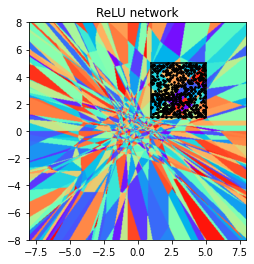

In [788]:
plt.imshow(shades, interpolation='bilinear', origin='lower', extent=[-8, 8, -8, 8])
plt.title(r"$f(x, y) = xy$")
plt.plot([1.0, 5.0], [1.0, 1.0], color='black')
plt.plot([5.0, 5.0], [1.0, 5.0], color='black')
plt.plot([1.0, 1.0], [1.0, 5.0], color='black')
plt.plot([1.0, 5.0], [5.0, 5.0], color='black')
plt.scatter(*zip(*xs_train.detach().cpu().numpy()), color='black', s=3)
# plt.ylim(ranges[0][0], ranges[0][1])
# plt.ylim(ranges[1][0], ranges[1][1])
plt.title("ReLU network")

Text(0.5, 1.0, 'ReLU network')

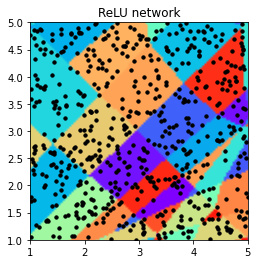

In [789]:
plt.imshow(shades, interpolation='bilinear', origin='lower', extent=[-8, 8, -8, 8])
plt.title(r"$f(x, y) = xy$")
plt.xlim(ranges[0][0], ranges[0][1])
plt.ylim(ranges[1][0], ranges[1][1])
plt.scatter(*zip(*xs_train.detach().cpu().numpy()), color='black', s=11)
plt.title("ReLU network")

(1.0, 5.0)

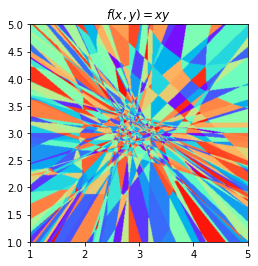

In [790]:
plt.imshow(shades, interpolation='bilinear', origin='lower', extent=[ranges[0][0], ranges[0][1], ranges[1][0], ranges[1][1]])
plt.title(r"$f(x, y) = xy$")
plt.xlim(ranges[0][0], ranges[0][1])
plt.ylim(ranges[1][0], ranges[1][1])
# plt.scatter(*zip(*xs_train.detach().cpu().numpy()), color='black', s=11)

### visualize the simplex solution

In [791]:
N = 200
xy = torch.meshgrid(torch.linspace(ranges[0][0]+0.0, ranges[0][1]-0.0, N, device=device), 
                      torch.linspace(ranges[1][0]+0.0, ranges[1][1]-0.0, N, device=device), indexing='xy')
xs_grid = torch.cat([xy[0].flatten().unsqueeze(dim=1), xy[1].flatten().unsqueeze(dim=1)], dim=1)

In [792]:
jacobians = []
for i in tqdm(range(N**2)):
    x = xs_grid[i].detach().cpu().numpy()
    dx = 1e-8
    dfdx = (f(x + np.array([dx, 0.0])) - f(x)) / dx
    dfdy = (f(x + np.array([0.0, dx])) - f(x)) / dx
    jac = np.array([dfdx, dfdy]).flatten()
    jac = np.round(jac, 4)
    jacobians.append(jac)


jacobians_py = [tuple(jac.tolist()) for jac in jacobians]

# min_angle = 
jacobian_to_color = dict()
for jpy in set(jacobians_py):
    if np.any(np.isnan(jpy)):
        jacobian_to_color['nan'] = np.array([1., 1., 1.]) # white background
    else:
#         jacobian_to_color[jpy] = matplotlib.cm.gnuplot2((np.arctan2(jpy[1], jpy[0]) + np.pi)/(2*np.pi))[:-1]
        jacobian_to_color[jpy] = matplotlib.cm.rainbow(np.random.rand())[:-1]
    
# jacobian_to_color = {jpy: (1.0 if np.any(np.isnan(jpy)) else np.arctan2(jpy[0], jpy[1])) for jpy in set(jacobians_py)}

  0%|          | 0/40000 [00:00<?, ?it/s]

In [793]:
jacobians_grid = np.array(jacobians).reshape((N, N, 2))
max_jacobian_norm = np.nanmax(np.linalg.norm(jacobians_grid, ord=2, axis=2))

shades = np.zeros((N, N, 3))
for i in range(N):
    for j in range(N):
        if np.any(np.isnan(jacobians_grid[i, j])):
            shades[i, j] = jacobian_to_color['nan']
        else:
#             shades[i, j] = color_scheme(jacobians_grid[i, j], mag_norm=max_jacobian_norm)
            shades[i, j] = jacobian_to_color[tuple(jacobians_grid[i, j].tolist())]

Text(0.5, 1.0, 'simplex')

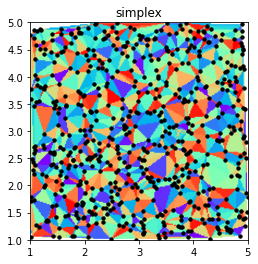

In [795]:
plt.imshow(shades, interpolation='bilinear', origin='lower', extent=[ranges[0][0], ranges[0][1], ranges[1][0], ranges[1][1]])
plt.title(r"$f(x, y) = xy$")
plt.ylim(ranges[0][0], ranges[0][1])
plt.ylim(ranges[1][0], ranges[1][1])
plt.scatter(*zip(*xs_train.detach().cpu().numpy()), color='black', s=11)
plt.title("simplex")

### Okay so arguably the reason why my ReLU experiments are scaling worse than they should is that the data is not centered around the origin. The linear regions away from the origin are large, and the linear regions close to the origin are small. So I need to just shift and scale the data so that it is in a good region.

### Let's visualize the linear regions at network initialization

In [4]:
eqn = 'Z.008'
width = 10
depth = 3
lr = 1e-3
activation = 'ReLU'
N_TEST_POINTS = 30000
TEST_COMPACTIFICATION = 0.8
MAX_TRAIN_ITERS = 25000
MAX_BATCH_SIZE = 30000
spreadsheet = "../equations.csv"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 0

In [5]:
torch.set_default_dtype(dtype)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [6]:
device

device(type='cuda', index=0)

In [7]:
equations = pd.read_csv(spreadsheet)
row = equations[equations['Equation'] == eqn].iloc[0]
dimension = int(row['# variables'])
formula = row['Formula']
variables = [row[f'v{i}_name'] for i in range(1, dimension+1)]
ranges = [(row[f'v{i}_low'], row[f'v{i}_high']) for i in range(1, dimension+1)]
target = lambdify(variables, parse_expr(formula))

In [8]:
TRAIN_POINTS = parameters(width, depth, dimension) // (dimension + 1)
# ex.info['TRAIN_POINTS'] = TRAIN_POINTS
# _log.debug(f"TRAIN_POINTS: {TRAIN_POINTS}")

# create datasets
ls = np.array([ranges[i][0] for i in range(dimension)])
hs = np.array([ranges[i][1] for i in range(dimension)])
xs_train = np.random.uniform(low=ls, high=hs, size=(TRAIN_POINTS, dimension))
ys_train = target(*[xs_train[:, i] for i in range(dimension)])

cs = (hs + ls) / 2
ws = (hs - ls) * TEST_COMPACTIFICATION
ls, hs = cs - ws / 2, cs + ws / 2
xs_test = np.random.uniform(low=ls, high=hs, size=(N_TEST_POINTS, dimension))
ys_test = target(*[xs_test[:, i] for i in range(dimension)])

xs_train = torch.from_numpy(xs_train).to(device)
ys_train = torch.from_numpy(ys_train).to(device).unsqueeze(dim=1)
xs_test = torch.from_numpy(xs_test).to(device)
ys_test = torch.from_numpy(ys_test).to(device).unsqueeze(dim=1)

In [9]:
ys_test.shape

torch.Size([30000, 1])

In [10]:
assert xs_train.dtype == dtype
assert ys_train.dtype == dtype
assert xs_test.dtype == dtype
assert ys_test.dtype == dtype

if activation == 'ReLU':
    activation_fn = nn.ReLU
elif activation == 'Tanh':
    activation_fn = nn.Tanh
elif activation == 'Sigmoid':
    activation_fn = nn.Sigmoid
else:
    assert False, f"Unrecognized activation function identifier: {activation}"

# create model
layers = []
for i in range(depth):
    if i == 0:
        layers.append(nn.Linear(dimension, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        layers.append(nn.Linear(width, 1))
    else:
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())
mlp = nn.Sequential(*layers).to(device)
# _log.debug("Created model.")
# _log.debug(f"Model has {sum(t.numel() for t in mlp.parameters())} parameters")

In [11]:
N = 400
# xy = torch.meshgrid(torch.linspace(ranges[0][0], ranges[0][1], N, device=device), 
#                       torch.linspace(ranges[1][0], ranges[1][1], N, device=device), indexing='xy')
xy = torch.meshgrid(torch.linspace(-8, 8, N, device=device), 
                      torch.linspace(-8, 8, N, device=device), indexing='xy')
xs_grid = torch.cat([xy[0].flatten().unsqueeze(dim=1), xy[1].flatten().unsqueeze(dim=1)], dim=1)

In [12]:
jacobians = []
for i in tqdm(range(N**2)):
    jacobians.append(torch.autograd.functional.jacobian(mlp, inputs=xs_grid[i]).detach().cpu().numpy())
jacobians_py = [tuple(j.tolist()[0]) for j in jacobians]

  0%|          | 0/160000 [00:00<?, ?it/s]

In [16]:
import matplotlib
import matplotlib.pyplot as plt

In [17]:
jacobian_to_color = {jpy: matplotlib.cm.rainbow(np.random.rand())[:3] for jpy in set(jacobians_py)}

In [18]:
jacobians_grid = np.array(jacobians).reshape((N, N, 2))
shades = np.zeros((N, N, 3))
for i in range(N):
    for j in range(N):
        shades[i, j] = jacobian_to_color[tuple(jacobians_grid[i, j].tolist())]

Text(0.5, 1.0, 'ReLU network (at initialization)')

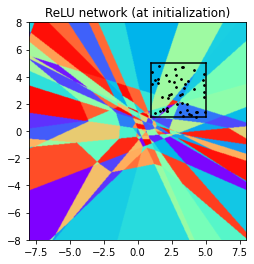

In [20]:
plt.imshow(shades, interpolation='bilinear', origin='lower', extent=[-8, 8, -8, 8])
plt.title(r"$f(x, y) = xy$")
plt.plot([1.0, 5.0], [1.0, 1.0], color='black')
plt.plot([5.0, 5.0], [1.0, 5.0], color='black')
plt.plot([1.0, 1.0], [1.0, 5.0], color='black')
plt.plot([1.0, 5.0], [5.0, 5.0], color='black')
plt.scatter(*zip(*xs_train.detach().cpu().numpy()), color='black', s=3)
# plt.ylim(ranges[0][0], ranges[0][1])
# plt.ylim(ranges[1][0], ranges[1][1])
plt.title("ReLU network (at initialization)")

Text(0.5, 1.0, 'ReLU network (at initialization)')

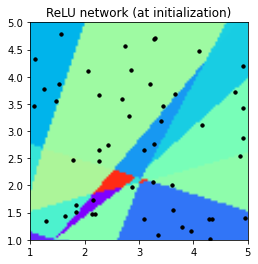

In [21]:
plt.imshow(shades, interpolation='bilinear', origin='lower', extent=[-8, 8, -8, 8])
plt.title(r"$f(x, y) = xy$")
plt.xlim(ranges[0][0], ranges[0][1])
plt.ylim(ranges[1][0], ranges[1][1])
plt.scatter(*zip(*xs_train.detach().cpu().numpy()), color='black', s=11)
plt.title("ReLU network (at initialization)")

### Alright, so both at initialization and at the end of training, the density of linear regions is much higher near the origin than away from it, where AI Feynman data is.

We want to shift and scale data to have mean zero and variance 1 (?). What's the cleanest way to do this in PyTorch?

In [250]:
torch.use_deterministic_algorithms(False)

### unnormalized data

In [341]:
eqn = 'Z.008'
width = 20
depth = 3
lr = 1e-3
activation = 'ReLU'
N_TEST_POINTS = 30000
TEST_COMPACTIFICATION = 0.8
MAX_TRAIN_ITERS = 25000
MAX_BATCH_SIZE = 30000
spreadsheet = "../equations.csv"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 0

In [342]:
torch.set_default_dtype(dtype)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [343]:
device

device(type='cuda', index=0)

In [344]:
equations = pd.read_csv(spreadsheet)
row = equations[equations['Equation'] == eqn].iloc[0]
dimension = int(row['# variables'])
formula = row['Formula']
variables = [row[f'v{i}_name'] for i in range(1, dimension+1)]
ranges = [(row[f'v{i}_low'], row[f'v{i}_high']) for i in range(1, dimension+1)]
target = lambdify(variables, parse_expr(formula))

In [345]:
TRAIN_POINTS = parameters(width, depth, dimension) // (dimension + 1)
# ex.info['TRAIN_POINTS'] = TRAIN_POINTS
# _log.debug(f"TRAIN_POINTS: {TRAIN_POINTS}")

# create datasets
ls = np.array([ranges[i][0] for i in range(dimension)])
hs = np.array([ranges[i][1] for i in range(dimension)])
xs_train_unnormalized = np.random.uniform(low=ls, high=hs, size=(TRAIN_POINTS, dimension))
ys_train = target(*[xs_train_unnormalized[:, i] for i in range(dimension)])

cs = (hs + ls) / 2
ws = (hs - ls) * TEST_COMPACTIFICATION
ls, hs = cs - ws / 2, cs + ws / 2
xs_test_unnormalized = np.random.uniform(low=ls, high=hs, size=(N_TEST_POINTS, dimension))
ys_test = target(*[xs_test_unnormalized[:, i] for i in range(dimension)])

xs_train_unnormalized = torch.from_numpy(xs_train_unnormalized).to(device)
ys_train = torch.from_numpy(ys_train).to(device).unsqueeze(dim=1)
xs_test_unnormalized = torch.from_numpy(xs_test_unnormalized).to(device)
ys_test = torch.from_numpy(ys_test).to(device).unsqueeze(dim=1)

In [346]:
## Simplex interpolation first

from scipy import spatial, interpolate

tri = spatial.Delaunay(xs_train_unnormalized.detach().cpu().numpy())
f = interpolate.LinearNDInterpolator(tri, ys_train.detach().cpu().numpy())

# _log.debug("Evaluating model")
preds = f(xs_test_unnormalized.detach().cpu().numpy())
valid_idx = ~np.isnan(preds)
rmse_loss = np.sqrt(np.mean(np.power(preds[valid_idx] - ys_test.detach().cpu().numpy()[valid_idx], 2)))

In [347]:
assert xs_train_unnormalized.dtype == dtype
assert ys_train.dtype == dtype
assert xs_test_unnormalized.dtype == dtype
assert ys_test.dtype == dtype

if activation == 'ReLU':
    activation_fn = nn.ReLU
elif activation == 'Tanh':
    activation_fn = nn.Tanh
elif activation == 'Sigmoid':
    activation_fn = nn.Sigmoid
else:
    assert False, f"Unrecognized activation function identifier: {activation}"

# create model
layers = []
for i in range(depth):
    if i == 0:
        layers.append(nn.Linear(dimension, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        layers.append(nn.Linear(width, 1))
    else:
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())
mlp = nn.Sequential(*layers).to(device)
# _log.debug("Created model.")
# _log.debug(f"Model has {sum(t.numel() for t in mlp.parameters())} parameters") 

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(mlp.parameters(), lr=lr)

# ex.info['train'] = list()
train = list()
# ex.info['test'] = list()
test = list()
min_train = float('inf')
min_test = float('inf')
test_at_min_train = float('inf')

k = 0
for step in tqdm(range(MAX_TRAIN_ITERS)):
    optim.zero_grad()
    if TRAIN_POINTS <= MAX_BATCH_SIZE:
        ys_pred = mlp(xs_train_unnormalized)
        l = loss_fn(ys_train, ys_pred)
    else:
        sample_idx = torch.arange(k, k+MAX_BATCH_SIZE, 1) % TRAIN_POINTS
        xs_batch, ys_batch = xs_train_unnormalized[sample_idx], ys_train[sample_idx]
        ys_pred = mlp(xs_batch)
        l = loss_fn(ys_batch, ys_pred)
        k += MAX_BATCH_SIZE
    l.backward()
    optim.step()
    with torch.no_grad():
        train_l = torch.sqrt(l).item()
        test_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_test_unnormalized) - ys_test, 2))).item()
        if train_l < min_train:
            min_train = train_l
            test_at_min_train = test_l
        min_test = test_l if test_l < min_test else min_test
        if step % 100 == 0:
            # ex.info['train'].append(train_l)
            # ex.info['test'].append(test_l)
            train.append(train_l)
            test.append(test_l)
    # if step % (MAX_TRAIN_ITERS // 10) == 0:
    #     _log.debug("{:.0f}% done with training".format(step / MAX_TRAIN_ITERS * 100))
# ex.info['min_train'] = min_train
# ex.info['min_test'] = min_test
# ex.info['test_at_min_train'] = test_at_min_train
# _log.debug("Test loss: {:.3e}".format(test_at_min_train))

  0%|          | 0/25000 [00:00<?, ?it/s]

In [348]:
min_test

0.5355542012134172

In [349]:
N = 400
# xy = torch.meshgrid(torch.linspace(ranges[0][0], ranges[0][1], N, device=device), 
#                       torch.linspace(ranges[1][0], ranges[1][1], N, device=device), indexing='xy')
xy = torch.meshgrid(torch.linspace(1, 5, N, device=device), 
                      torch.linspace(1, 5, N, device=device), indexing='xy')
xs_grid_unnormalized = torch.cat([xy[0].flatten().unsqueeze(dim=1), xy[1].flatten().unsqueeze(dim=1)], dim=1)

In [350]:
jacobians = []
for i in tqdm(range(N**2)):
    jacobians.append(torch.autograd.functional.jacobian(mlp, inputs=xs_grid_unnormalized[i]).detach().cpu().numpy())
jacobians_py = [tuple(j.tolist()[0]) for j in jacobians]

  0%|          | 0/160000 [00:00<?, ?it/s]

In [351]:
jacobian_to_color = {jpy: matplotlib.cm.rainbow(np.random.rand())[:3] for jpy in set(jacobians_py)}

In [352]:
jacobians_grid = np.array(jacobians).reshape((N, N, 2))
shades_unnormalized = np.zeros((N, N, 3))
for i in range(N):
    for j in range(N):
        shades_unnormalized[i, j] = jacobian_to_color[tuple(jacobians_grid[i, j].tolist())]

Text(0.5, 1.0, 'ReLU network')

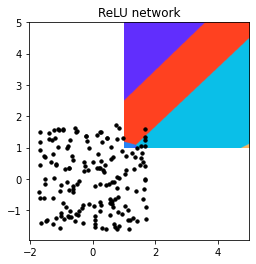

In [353]:
plt.imshow(shades_unnormalized, interpolation='bilinear', origin='lower', extent=[
    xs_grid_unnormalized[:, 0].min().cpu().numpy(), 
    xs_grid_unnormalized[:, 0].max().cpu().numpy(), 
    xs_grid_unnormalized[:, 1].min().cpu().numpy(), 
    xs_grid_unnormalized[:, 1].max().cpu().numpy()
#     0, 6, 0, 6
])
# plt.title(r"$f(x, y) = xy$")
# plt.plot([1.0, 5.0], [1.0, 1.0], color='black')
# plt.plot([5.0, 5.0], [1.0, 5.0], color='black')
# plt.plot([1.0, 1.0], [1.0, 5.0], color='black')
# plt.plot([1.0, 5.0], [5.0, 5.0], color='black')
plt.scatter(*zip(*xs_train.detach().cpu().numpy()), color='black', s=11)
# plt.ylim(ranges[0][0], ranges[0][1])
# plt.ylim(ranges[1][0], ranges[1][1])
plt.title("ReLU network")

In [354]:
def create_normalizer(mean, std):
    """Create a function to normalize data of the form (N, d) given the means
    and stds along each of the d columns.

    Args:
        mean: (mean[1], ..., mean[d])
        std: (std[1], ..., std[d])
    """
    assert len(mean) == len(std)
    def normalize(x):
        return torch.stack([(x[:, i] - mean[i]) / std[i] for i in range(len(mean))], dim=1)
    return normalize

In [355]:
eqn = 'Z.008'
width = 20
depth = 3
lr = 1e-3
activation = 'ReLU'
N_TEST_POINTS = 30000
TEST_COMPACTIFICATION = 0.8
MAX_TRAIN_ITERS = 25000
MAX_BATCH_SIZE = 30000
spreadsheet = "../equations.csv"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 0

In [356]:
torch.set_default_dtype(dtype)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [357]:
device

device(type='cuda', index=0)

In [358]:
equations = pd.read_csv(spreadsheet)
row = equations[equations['Equation'] == eqn].iloc[0]
dimension = int(row['# variables'])
formula = row['Formula']
variables = [row[f'v{i}_name'] for i in range(1, dimension+1)]
ranges = [(row[f'v{i}_low'], row[f'v{i}_high']) for i in range(1, dimension+1)]
target = lambdify(variables, parse_expr(formula))

In [359]:
TRAIN_POINTS = parameters(width, depth, dimension) // (dimension + 1)
# ex.info['TRAIN_POINTS'] = TRAIN_POINTS
# _log.debug(f"TRAIN_POINTS: {TRAIN_POINTS}")

# create datasets
ls = np.array([ranges[i][0] for i in range(dimension)])
hs = np.array([ranges[i][1] for i in range(dimension)])
xs_train = np.random.uniform(low=ls, high=hs, size=(TRAIN_POINTS, dimension))
ys_train = target(*[xs_train[:, i] for i in range(dimension)])

cs = (hs + ls) / 2
ws = (hs - ls) * TEST_COMPACTIFICATION
ls, hs = cs - ws / 2, cs + ws / 2
xs_test = np.random.uniform(low=ls, high=hs, size=(N_TEST_POINTS, dimension))
ys_test = target(*[xs_test[:, i] for i in range(dimension)])

xs_train = torch.from_numpy(xs_train).to(device)
ys_train = torch.from_numpy(ys_train).to(device).unsqueeze(dim=1)
xs_test = torch.from_numpy(xs_test).to(device)
ys_test = torch.from_numpy(ys_test).to(device).unsqueeze(dim=1)

In [360]:
normalize = create_normalizer(xs_train.mean(dim=0), xs_train.std(dim=0))

xs_train = normalize(xs_train)
xs_test = normalize(xs_test)

In [361]:
## Simplex interpolation first

from scipy import spatial, interpolate

tri = spatial.Delaunay(xs_train.detach().cpu().numpy())
f = interpolate.LinearNDInterpolator(tri, ys_train.detach().cpu().numpy())

# _log.debug("Evaluating model")
preds = f(xs_test.detach().cpu().numpy())
valid_idx = ~np.isnan(preds)
rmse_loss = np.sqrt(np.mean(np.power(preds[valid_idx] - ys_test.detach().cpu().numpy()[valid_idx], 2)))

In [362]:
assert xs_train.dtype == dtype
assert ys_train.dtype == dtype
assert xs_test.dtype == dtype
assert ys_test.dtype == dtype

if activation == 'ReLU':
    activation_fn = nn.ReLU
elif activation == 'Tanh':
    activation_fn = nn.Tanh
elif activation == 'Sigmoid':
    activation_fn = nn.Sigmoid
else:
    assert False, f"Unrecognized activation function identifier: {activation}"

# create model
layers = []
for i in range(depth):
    if i == 0:
        layers.append(nn.Linear(dimension, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        layers.append(nn.Linear(width, 1))
    else:
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())
mlp = nn.Sequential(*layers).to(device)
# _log.debug("Created model.")
# _log.debug(f"Model has {sum(t.numel() for t in mlp.parameters())} parameters") 

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(mlp.parameters(), lr=lr)

# ex.info['train'] = list()
train = list()
# ex.info['test'] = list()
test = list()
min_train = float('inf')
min_test = float('inf')
test_at_min_train = float('inf')

k = 0
for step in tqdm(range(MAX_TRAIN_ITERS)):
    optim.zero_grad()
    if TRAIN_POINTS <= MAX_BATCH_SIZE:
        ys_pred = mlp(xs_train)
        l = loss_fn(ys_train, ys_pred)
    else:
        sample_idx = torch.arange(k, k+MAX_BATCH_SIZE, 1) % TRAIN_POINTS
        xs_batch, ys_batch = xs_train[sample_idx], ys_train[sample_idx]
        ys_pred = mlp(xs_batch)
        l = loss_fn(ys_batch, ys_pred)
        k += MAX_BATCH_SIZE
    l.backward()
    optim.step()
    with torch.no_grad():
        train_l = torch.sqrt(l).item()
        test_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_test) - ys_test, 2))).item()
        if train_l < min_train:
            min_train = train_l
            test_at_min_train = test_l
        min_test = test_l if test_l < min_test else min_test
        if step % 100 == 0:
            # ex.info['train'].append(train_l)
            # ex.info['test'].append(test_l)
            train.append(train_l)
            test.append(test_l)
    # if step % (MAX_TRAIN_ITERS // 10) == 0:
    #     _log.debug("{:.0f}% done with training".format(step / MAX_TRAIN_ITERS * 100))
# ex.info['min_train'] = min_train
# ex.info['min_test'] = min_test
# ex.info['test_at_min_train'] = test_at_min_train
# _log.debug("Test loss: {:.3e}".format(test_at_min_train))

  0%|          | 0/25000 [00:00<?, ?it/s]

In [363]:
min_test

0.05656662349755255

In [364]:
N = 400
# xy = torch.meshgrid(torch.linspace(ranges[0][0], ranges[0][1], N, device=device), 
#                       torch.linspace(ranges[1][0], ranges[1][1], N, device=device), indexing='xy')
xy = torch.meshgrid(torch.linspace(1, 5, N, device=device), 
                      torch.linspace(1, 5, N, device=device), indexing='xy')
xs_grid = torch.cat([xy[0].flatten().unsqueeze(dim=1), xy[1].flatten().unsqueeze(dim=1)], dim=1)
xs_grid = normalize(xs_grid)

In [365]:
jacobians = []
for i in tqdm(range(N**2)):
    jacobians.append(torch.autograd.functional.jacobian(mlp, inputs=xs_grid[i]).detach().cpu().numpy())
jacobians_py = [tuple(j.tolist()[0]) for j in jacobians]

  0%|          | 0/160000 [00:00<?, ?it/s]

In [366]:
jacobian_to_color = {jpy: matplotlib.cm.rainbow(np.random.rand())[:3] for jpy in set(jacobians_py)}

In [367]:
jacobians_grid = np.array(jacobians).reshape((N, N, 2))
shades = np.zeros((N, N, 3))
for i in range(N):
    for j in range(N):
        shades[i, j] = jacobian_to_color[tuple(jacobians_grid[i, j].tolist())]

Text(0.5, 1.0, 'ReLU network')

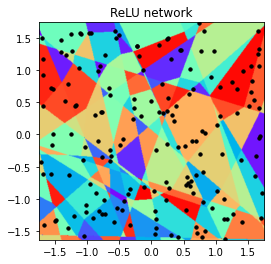

In [368]:
plt.imshow(shades, interpolation='bilinear', origin='lower', extent=[
    xs_grid[:, 0].min().cpu().numpy(), 
    xs_grid[:, 0].max().cpu().numpy(), 
    xs_grid[:, 1].min().cpu().numpy(), 
    xs_grid[:, 1].max().cpu().numpy()
#     0, 6, 0, 6
])
# plt.title(r"$f(x, y) = xy$")
# plt.plot([1.0, 5.0], [1.0, 1.0], color='black')
# plt.plot([5.0, 5.0], [1.0, 5.0], color='black')
# plt.plot([1.0, 1.0], [1.0, 5.0], color='black')
# plt.plot([1.0, 5.0], [5.0, 5.0], color='black')
plt.scatter(*zip(*xs_train.detach().cpu().numpy()), color='black', s=11)
# plt.ylim(ranges[0][0], ranges[0][1])
# plt.ylim(ranges[1][0], ranges[1][1])
plt.title("ReLU network")

In [376]:
N = 400
xy = torch.meshgrid(torch.linspace(1, 5, N, device=device), 
                      torch.linspace(1, 5, N, device=device), indexing='xy')
xs_grid = torch.cat([xy[0].flatten().unsqueeze(dim=1), xy[1].flatten().unsqueeze(dim=1)], dim=1)
xs_grid = normalize(xs_grid)

jacobians = []
for i in tqdm(range(N**2)):
    x = xs_grid[i].detach().cpu().numpy()
    dx = 1e-8
    dfdx = (f(x + np.array([dx, 0.0])) - f(x)) / dx
    dfdy = (f(x + np.array([0.0, dx])) - f(x)) / dx
    jac = np.array([dfdx, dfdy]).flatten()
    jac = np.round(jac, 3)
    jacobians.append(jac)


jacobians_py = [tuple(jac.tolist()) for jac in jacobians]

# min_angle = 
jacobian_to_color = dict()
for jpy in set(jacobians_py):
    if np.any(np.isnan(jpy)):
        jacobian_to_color['nan'] = np.array([1., 1., 1.]) # white background
    else:
#         jacobian_to_color[jpy] = matplotlib.cm.gnuplot2((np.arctan2(jpy[1], jpy[0]) + np.pi)/(2*np.pi))[:-1]
        jacobian_to_color[jpy] = matplotlib.cm.rainbow(np.random.rand())[:-1]
    
# jacobian_to_color = {jpy: (1.0 if np.any(np.isnan(jpy)) else np.arctan2(jpy[0], jpy[1])) for jpy in set(jacobians_py)}

jacobians_grid = np.array(jacobians).reshape((N, N, 2))
max_jacobian_norm = np.nanmax(np.linalg.norm(jacobians_grid, ord=2, axis=2))

shades_simplex = np.zeros((N, N, 3))
for i in range(N):
    for j in range(N):
        if np.any(np.isnan(jacobians_grid[i, j])):
            shades_simplex[i, j] = jacobian_to_color['nan']
        else:
#             shades_simplex[i, j] = color_scheme(jacobians_grid[i, j], mag_norm=max_jacobian_norm)
            shades_simplex[i, j] = jacobian_to_color[tuple(jacobians_grid[i, j].tolist())]

  0%|          | 0/160000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'simplex')

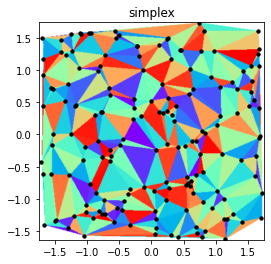

In [377]:
plt.imshow(shades_simplex, interpolation='bilinear', origin='lower', extent=[
    xs_grid[:, 0].min().cpu().numpy(), 
    xs_grid[:, 0].max().cpu().numpy(), 
    xs_grid[:, 1].min().cpu().numpy(), 
    xs_grid[:, 1].max().cpu().numpy()
])
plt.title(r"$f(x, y) = xy$")
# plt.ylim(ranges[0][0], ranges[0][1])
# plt.ylim(ranges[1][0], ranges[1][1])
plt.scatter(*zip(*xs_train.detach().cpu().numpy()), color='black', s=11)
plt.title("simplex")

In [378]:
[
    xs_grid[:, 0].min().cpu().numpy(), 
    xs_grid[:, 0].max().cpu().numpy(), 
    xs_grid[:, 1].min().cpu().numpy(), 
    xs_grid[:, 1].max().cpu().numpy()
]

[array(-1.74909162), array(1.7443129), array(-1.63340125), array(1.73812842)]

In [379]:
# xs_train_normalized = normalize(xs_train)

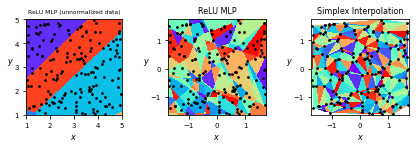

In [397]:
plt.figure(figsize=(6.0, 2.0))

plt.subplot(1, 3, 1)
plt.imshow(shades_unnormalized, interpolation='none', origin='lower', extent=[
    xs_grid_unnormalized[:, 0].min().cpu().numpy(), 
    xs_grid_unnormalized[:, 0].max().cpu().numpy(), 
    xs_grid_unnormalized[:, 1].min().cpu().numpy(), 
    xs_grid_unnormalized[:, 1].max().cpu().numpy()
])
# plt.title(r"$f(x, y) = xy$")
# plt.plot([1.0, 5.0], [1.0, 1.0], color='black')
# plt.plot([5.0, 5.0], [1.0, 5.0], color='black')
# plt.plot([1.0, 1.0], [1.0, 5.0], color='black')
# plt.plot([1.0, 5.0], [5.0, 5.0], color='black')
plt.scatter(*zip(*xs_train_unnormalized.detach().cpu().numpy()), color='black', s=3)
# plt.ylim(ranges[0][0], ranges[0][1])
# plt.ylim(ranges[1][0], ranges[1][1])
plt.title("ReLU MLP (unnormalized data)", fontsize=6)
plt.xlabel(r"$x$", fontsize=8)
plt.ylabel(r"$y$", rotation=0, fontsize=8)
plt.xticks([1, 2, 3, 4, 5], fontsize=7)
plt.yticks([1, 2, 3, 4, 5], fontsize=7)

plt.subplot(1, 3, 2)
plt.imshow(shades, interpolation='none', origin='lower', extent=[
    xs_grid[:, 0].min().cpu().numpy(), 
    xs_grid[:, 0].max().cpu().numpy(), 
    xs_grid[:, 1].min().cpu().numpy(), 
    xs_grid[:, 1].max().cpu().numpy()
])
# plt.title(r"$f(x, y) = xy$")
# plt.plot([1.0, 5.0], [1.0, 1.0], color='black')
# plt.plot([5.0, 5.0], [1.0, 5.0], color='black')
# plt.plot([1.0, 1.0], [1.0, 5.0], color='black')
# plt.plot([1.0, 5.0], [5.0, 5.0], color='black')
plt.scatter(*zip(*xs_train.detach().cpu().numpy()), color='black', s=3)
# plt.ylabel(ranges[0][0], ranges[0][1])
# plt.ylabel(ranges[1][0], ranges[1][1])
plt.title("ReLU MLP", fontsize=8)
plt.xlabel(r"$x$", fontsize=8)
plt.ylabel(r"$y$", rotation=0, fontsize=8)
plt.xticks([-1, 0, 1], fontsize=7)
plt.yticks([-1, 0, 1], fontsize=7)

plt.subplot(1, 3, 3)
plt.imshow(shades_simplex, interpolation='none', origin='lower', extent=[
    xs_grid[:, 0].min().cpu().numpy(), 
    xs_grid[:, 0].max().cpu().numpy(), 
    xs_grid[:, 1].min().cpu().numpy(), 
    xs_grid[:, 1].max().cpu().numpy()
])
# plt.xlim(-np.sqrt(12) / 2.0, np.sqrt(12) / 2.0)
# plt.ylim(-np.sqrt(12) / 2.0, np.sqrt(12) / 2.0)
plt.title(r"$f(x, y) = xy$")
# plt.ylabel(ranges[0][0], ranges[0][1])
# plt.ylabel(ranges[1][0], ranges[1][1])
plt.scatter(*zip(*xs_train.detach().cpu().numpy()), color='black', s=3)
plt.title("Simplex Interpolation", fontsize=8)
plt.xlabel(r"$x$", fontsize=8)
plt.ylabel(r"$y$", rotation=0, fontsize=8)
plt.xticks([-1, 0, 1], fontsize=7)
plt.yticks([-1, 0, 1], fontsize=7)

plt.tight_layout()

plt.savefig("figures/2d-linear-regions.pdf")

## record over a training run

In [393]:
eqn = 'Z.008'
width = 30
depth = 3
lr = 1e-3
activation = 'ReLU'
N_TEST_POINTS = 30000
TEST_COMPACTIFICATION = 0.8
MAX_TRAIN_ITERS = 25000
MAX_BATCH_SIZE = 30000
spreadsheet = "../equations.csv"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 0

In [394]:
torch.set_default_dtype(dtype)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [395]:
equations = pd.read_csv(spreadsheet)
row = equations[equations['Equation'] == eqn].iloc[0]
dimension = int(row['# variables'])
formula = row['Formula']
variables = [row[f'v{i}_name'] for i in range(1, dimension+1)]
ranges = [(row[f'v{i}_low'], row[f'v{i}_high']) for i in range(1, dimension+1)]
target = lambdify(variables, parse_expr(formula))

In [396]:
TRAIN_POINTS = parameters(width, depth, dimension) // (dimension + 1)
# ex.info['TRAIN_POINTS'] = TRAIN_POINTS
# _log.debug(f"TRAIN_POINTS: {TRAIN_POINTS}")

# create datasets
ls = np.array([ranges[i][0] for i in range(dimension)])
hs = np.array([ranges[i][1] for i in range(dimension)])
xs_train = np.random.uniform(low=ls, high=hs, size=(TRAIN_POINTS, dimension))
ys_train = target(*[xs_train[:, i] for i in range(dimension)])

cs = (hs + ls) / 2
ws = (hs - ls) * TEST_COMPACTIFICATION
ls, hs = cs - ws / 2, cs + ws / 2
xs_test = np.random.uniform(low=ls, high=hs, size=(N_TEST_POINTS, dimension))
ys_test = target(*[xs_test[:, i] for i in range(dimension)])

xs_train = torch.from_numpy(xs_train).to(device)
ys_train = torch.from_numpy(ys_train).to(device).unsqueeze(dim=1)
xs_test = torch.from_numpy(xs_test).to(device)
ys_test = torch.from_numpy(ys_test).to(device).unsqueeze(dim=1)

In [397]:
assert xs_train.dtype == dtype
assert ys_train.dtype == dtype
assert xs_test.dtype == dtype
assert ys_test.dtype == dtype

if activation == 'ReLU':
    activation_fn = nn.ReLU
elif activation == 'Tanh':
    activation_fn = nn.Tanh
elif activation == 'Sigmoid':
    activation_fn = nn.Sigmoid
else:
    assert False, f"Unrecognized activation function identifier: {activation}"

# create model
layers = []
for i in range(depth):
    if i == 0:
        layers.append(nn.Linear(dimension, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        layers.append(nn.Linear(width, 1))
    else:
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())
mlp = nn.Sequential(*layers).to(device)
# _log.debug("Created model.")
# _log.debug(f"Model has {sum(t.numel() for t in mlp.parameters())} parameters") 

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(mlp.parameters(), lr=lr)

# ex.info['train'] = list()
train = list()
# ex.info['test'] = list()
test = list()
min_train = float('inf')
min_test = float('inf')
test_at_min_train = float('inf')

N = 200
xy = torch.meshgrid(torch.linspace(ranges[0][0], ranges[0][1], N, device=device), 
                      torch.linspace(ranges[1][0], ranges[1][1], N, device=device), indexing='ij')
xs_grid = torch.cat([xy[0].flatten().unsqueeze(dim=1), xy[1].flatten().unsqueeze(dim=1)], dim=1)

jacobians_timeseries = []

k = 0
for step in tqdm(range(MAX_TRAIN_ITERS)):
    optim.zero_grad()
    if TRAIN_POINTS <= MAX_BATCH_SIZE:
        ys_pred = mlp(xs_train)
        l = loss_fn(ys_train, ys_pred)
    else:
        sample_idx = torch.arange(k, k+MAX_BATCH_SIZE, 1) % TRAIN_POINTS
        xs_batch, ys_batch = xs_train[sample_idx], ys_train[sample_idx]
        ys_pred = mlp(xs_batch)
        l = loss_fn(ys_batch, ys_pred)
        k += MAX_BATCH_SIZE
    l.backward()
    optim.step()
    with torch.no_grad():
        train_l = torch.sqrt(l).item()
        test_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_test) - ys_test, 2))).item()
        if train_l < min_train:
            min_train = train_l
            test_at_min_train = test_l
        min_test = test_l if test_l < min_test else min_test
        if step % 100 == 0:
            # ex.info['train'].append(train_l)
            # ex.info['test'].append(test_l)
            train.append(train_l)
            test.append(test_l)
    if step % (MAX_TRAIN_ITERS // 60) == 0:
        jacobians = []
        for i in tqdm(range(N**2), leave=False):
            jacobians.append(torch.autograd.functional.jacobian(mlp, inputs=xs_grid[i]).detach().cpu().numpy())
        jacobians_timeseries.append(jacobians)
#         jacobians_py = [tuple(j.tolist()[0]) for j in jacobians]
        
    # if step % (MAX_TRAIN_ITERS // 10) == 0:
    #     _log.debug("{:.0f}% done with training".format(step / MAX_TRAIN_ITERS * 100))
# ex.info['min_train'] = min_train
# ex.info['min_test'] = min_test
# ex.info['test_at_min_train'] = test_at_min_train
# _log.debug("Test loss: {:.3e}".format(test_at_min_train))

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

(1.0, 5.0)

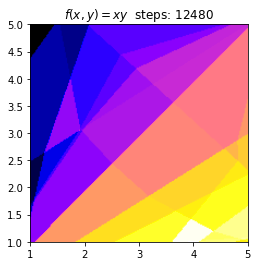

In [398]:
steps = list(range(0, MAX_TRAIN_ITERS, MAX_TRAIN_ITERS // 60))
jacobians = jacobians_timeseries[30]
jacobians_py = [tuple(j.tolist()[0]) for j in jacobians]

jacobian_to_color = {jpy: np.arctan2(jpy[0], jpy[1]) for jpy in set(jacobians_py)}

jacobians_grid = np.array(jacobians).reshape((N, N, 2))
shades = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        shades[i, j] = jacobian_to_color[tuple(jacobians_grid[i, j].tolist())]
        
plt.imshow(shades, interpolation='bilinear', origin='lower', cmap='gnuplot2', extent=[ranges[0][0], ranges[0][1], ranges[1][0], ranges[1][1]])
plt.title(r"$f(x, y) = xy$" + f"  steps: {steps[30]}")
plt.ylim(ranges[0][0], ranges[0][1])
plt.ylim(ranges[1][0], ranges[1][1])

In [390]:
from celluloid import Camera

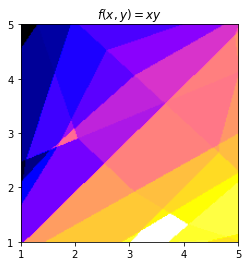

In [401]:
fig = plt.figure()
camera = Camera(fig)

steps = list(range(0, MAX_TRAIN_ITERS, MAX_TRAIN_ITERS // 60))
for k in range(len(jacobians_timeseries)):
    jacobians = jacobians_timeseries[k]
    jacobians_py = [tuple(j.tolist()[0]) for j in jacobians]

    jacobian_to_color = {jpy: np.arctan2(jpy[0], jpy[1]) for jpy in set(jacobians_py)}

    jacobians_grid = np.array(jacobians).reshape((N, N, 2))
    shades = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            shades[i, j] = jacobian_to_color[tuple(jacobians_grid[i, j].tolist())]

    plt.imshow(shades, interpolation='bilinear', origin='lower', cmap='gnuplot2', extent=[ranges[0][0], ranges[0][1], ranges[1][0], ranges[1][1]])
#     plt.title(r"$f(x, y) = xy$" + f"  steps: {steps[30]}")
    plt.title(r"$f(x, y) = xy$")
    plt.ylim(ranges[0][0], ranges[0][1])
    plt.xlim(ranges[1][0], ranges[1][1])
    plt.xticks(np.linspace(ranges[1][0], ranges[1][1], 5))
    plt.yticks(np.linspace(ranges[0][0], ranges[0][1], 5))

    camera.snap()



In [402]:
animation = camera.animate()
animation.save('figures/animation.mp4', fps=10, dpi=250)

In [602]:
np.arctan2(-0.1, 1) + np.pi

3.0419240010986313